# import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
import seaborn as sns
from statistics import mean
import joblib 

# load in the file 

In [2]:
dataset = pd.read_csv(r'D:\Ngan\rmit\AI\ASM3\global_bleaching_environmental.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_6060\764645299.py:1: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'D:\Ngan\rmit\AI\ASM3\global_bleaching_environmental.csv')


In [3]:
dataset.head()

,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Reef_ID,Realm_Name,Ecoregion_Name,Country_Name,...,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Date,Site_Comments,Sample_Comments,Bleaching_Comments
0,2501,10324336,Donner,23.163,-82.5260,Atlantic,nd,Tropical Atlantic,Cuba and Cayman Islands,Cuba,...,5,0,0,0.74,7.25,0.18,2005-09-15,nd,nd,nd
1,3467,10324754,Donner,-17.575,-149.7833,Pacific,nd,Eastern Indo-Pacific,Society Islands French Polynesia,French Polynesia,...,4,0,0.26,0.67,4.65,0.19,1991-03-15,The bleaching does not appear to have gained ...,The bleaching does not appear to have gained ...,nd
2,1794,10323866,Donner,18.369,-64.5640,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United Kingdom,...,7,0,0,1.04,11.66,0.26,2006-01-15,nd,nd,nd
3,8647,10328028,Donner,17.760,-64.5680,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,4,0,0,0.75,5.64,0.2,2006-04-15,nd,nd,nd
4,8648,10328029,Donner,17.769,-64.5830,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,5,0,0,0.92,6.89,0.25,2006-04-15,nd,nd,nd


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                41361 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41361 non-null  object 
 9   Country_Name                           41361 non-null  object 
 10  State_Island_Province_Name             41361 non-null  object 
 11  Ci

## problem: 
find the bleaching percentage of coral 
# EDA: Exploratory Data Analysis

+ understand features, datatypes, number of samples
+ are there missing values? outliers?
+ data balanced? unbalanced?
+ correlations
+ what is the label? Method?

### Data Overview
By using ydata, we have the overview of the dataset

In [5]:
from ydata_profiling import ProfileReport
from ipywidgets import widgets

In [15]:
profile = ProfileReport(dataset, title = 'Data Overview')
profile.to_notebook_iframe()
#profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

According to the report, there are 9 categorical features, 8 numeric features, 41 text features, 3 unsupported and 1 datetime type.
The text datatype can be removed and the categorical features can be handled by One Hot Encoder.

There are 8 duplicated rows which can be removed.
The missing data is presented as 'nd'.

# Data Preprocessing
+ drop duplicates and unnecessary features
+ handle text features that has the datatype Object
+ handle missing values

## Drop duplicated rows

In [3]:
#handle duplicate
dataset = dataset.drop_duplicates(subset="Sample_ID")

## Drop unnecessary features

First, we drop text features: 'Country_Name','State_Island_Province_Name','City_Town_Name','Site_Name','Ecoregion_Name'

Then we remove all the ID information including Site, Sample, Reef, and comments

We have already had a Day, Month, Year column so 'Date' is unnecessary.

After the exploratory phase, we find out some categorical features only have 1 unique value so we will remove those as well.

In [4]:
dataset = dataset.drop(columns= ['Country_Name','State_Island_Province_Name','City_Town_Name','Site_Name','Ecoregion_Name'])
dataset = dataset.drop(columns= ['Site_ID','Sample_ID', 'Reef_ID', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments'])
dataset = dataset.drop(columns= ['Date'])
dataset = dataset.drop(columns= ['Bleaching_Level', 'SSTA_Mean'])

In [73]:
features = dataset.columns
features

Index(['Data_Source', 'Latitude_Degrees', 'Longitude_Degrees', 'Ocean_Name',
       'Realm_Name', 'Distance_to_Shore', 'Exposure', 'Turbidity',
       'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year', 'Depth_m',
       'Substrate_Name', 'Percent_Cover', 'Percent_Bleaching', 'ClimSST',
       'Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum',
       'Temperature_Maximum', 'Temperature_Kelvin_Standard_Deviation',
       'Windspeed', 'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Minimum',
       'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean'],
      dtype='

## Handling features that have dtype Object


In [ ]:
for i in dataset.select_dtypes(include='object').columns:
    print(dataset[i].unique())
    print('_______'*10)

Looking into the dataset, we see some numeric features having 'nd', which makes it become text type. We will inpute the 'nd' with nan.

In [10]:
dataset = dataset.replace('nd', np.nan)

Convert the features to numeric

In [11]:
dataset['Percent_Cover'] = pd.to_numeric(dataset["Percent_Cover"], errors="coerce")
dataset['Deph_m'] = pd.to_numeric(dataset["Depth_m"], errors="coerce")
dataset['ClimSST'] = pd.to_numeric(dataset["ClimSST"], errors="coerce")

dataset['Temperature_Kelvin'] = pd.to_numeric(dataset["Temperature_Kelvin"], errors="coerce")
dataset['Temperature_Mean'] = pd.to_numeric(dataset["Temperature_Mean"], errors="coerce")
dataset['Temperature_Minimum'] = pd.to_numeric(dataset["Temperature_Minimum"], errors="coerce")
dataset['Temperature_Maximum'] = pd.to_numeric(dataset["Temperature_Maximum"], errors="coerce")
dataset['Temperature_Kelvin_Standard_Deviation'] = pd.to_numeric(dataset["Temperature_Kelvin_Standard_Deviation"], errors="coerce")

dataset['Windspeed'] = pd.to_numeric(dataset["Windspeed"], errors="coerce")

dataset['SSTA'] = pd.to_numeric(dataset["SSTA"], errors="coerce")
dataset['SSTA_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_Standard_Deviation"], errors="coerce")
dataset['SSTA_Minimum'] = pd.to_numeric(dataset["SSTA_Minimum"], errors="coerce")
dataset['SSTA_Maximum'] = pd.to_numeric(dataset["SSTA_Maximum"], errors="coerce")

dataset['SSTA_Frequency'] = pd.to_numeric(dataset["SSTA_Frequency"], errors="coerce")
dataset['SSTA_Frequency_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_Frequency_Standard_Deviation"], errors="coerce")
dataset['SSTA_FrequencyMax'] = pd.to_numeric(dataset["SSTA_FrequencyMax"], errors="coerce")
dataset['SSTA_FrequencyMean'] = pd.to_numeric(dataset["SSTA_FrequencyMean"], errors="coerce")

dataset['SSTA_DHW'] = pd.to_numeric(dataset["SSTA_DHW"], errors="coerce")
dataset['SSTA_DHW_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_DHW_Standard_Deviation"], errors="coerce")
dataset['SSTA_DHWMax'] = pd.to_numeric(dataset["SSTA_DHWMax"], errors="coerce")
dataset['SSTA_DHWMean'] = pd.to_numeric(dataset["SSTA_DHWMean"], errors="coerce")

dataset['TSA'] = pd.to_numeric(dataset["TSA"], errors="coerce")
dataset['TSA_Standard_Deviation'] = pd.to_numeric(dataset["TSA_Standard_Deviation"], errors="coerce")
dataset['TSA_Minimum'] = pd.to_numeric(dataset["TSA_Minimum"], errors="coerce")
dataset['TSA_Maximum'] = pd.to_numeric(dataset["TSA_Maximum"], errors="coerce")
dataset['TSA_Mean'] = pd.to_numeric(dataset["TSA_Mean"], errors="coerce")

dataset['TSA_Frequency'] = pd.to_numeric(dataset["TSA_Frequency"], errors="coerce")
dataset['TSA_Frequency_Standard_Deviation'] = pd.to_numeric(dataset["TSA_Frequency_Standard_Deviation"], errors="coerce")
dataset['TSA_FrequencyMax'] = pd.to_numeric(dataset["TSA_FrequencyMax"], errors="coerce")
dataset['TSA_FrequencyMean'] = pd.to_numeric(dataset["TSA_FrequencyMean"], errors="coerce")

dataset['TSA_DHW'] = pd.to_numeric(dataset["TSA_DHW"], errors="coerce")
dataset['TSA_DHW_Standard_Deviation'] = pd.to_numeric(dataset["TSA_DHW_Standard_Deviation"], errors="coerce")
dataset['TSA_DHWMax'] = pd.to_numeric(dataset["TSA_DHWMax"], errors="coerce")
dataset['TSA_DHWMean'] = pd.to_numeric(dataset["TSA_DHWMean"], errors="coerce")

dataset['Distance_to_Shore'] = pd.to_numeric(dataset["Distance_to_Shore"], errors="coerce")
dataset['Turbidity'] = pd.to_numeric(dataset["Turbidity"], errors="coerce")
dataset['Percent_Bleaching'] = pd.to_numeric(dataset["Percent_Bleaching"], errors="coerce")



Hence, the number of numeric features go up to 41: 
- 'Latitude_Degrees','Longitude_Degrees', 'Cyclone_Frequency','Date_Day', 'Date_Month', 'Date_Year'
- 'Percent_Cover','Depth_m','ClimSST',
- 'Temperature_Kelvin','Temperature_Mean','Temperature_Minimum','Temperature_Maximum',
'Temperature_Kelvin_Standard_Deviation',
- 'Windspeed',
- 'SSTA','SSTA_Standard_Deviation', 'SSTA_Minimum','SSTA_Maximum',
- 'SSTA_Frequency',
'SSTA_Frequency_Standard_Deviation','SSTA_FrequencyMax','SSTA_FrequencyMean',
- 'SSTA_DHW','SSTA_DHW_Standard_Deviation','SSTA_DHWMax','SSTA_DHWMean',
- 'TSA','TSA_Standard_Deviation','TSA_Minimum','TSA_Maximum','TSA_Mean',
- 'TSA_Frequency','TSA_Frequency_Standard_Deviation','TSA_FrequencyMax','TSA_FrequencyMean',
- 'TSA_DHW','TSA_DHW_Standard_Deviation','TSA_DHWMax','TSA_DHWMean'
- 'Distance_to_Shore','Turbidity','Percent_Bleaching'


In [12]:
num_fea = dataset.select_dtypes(include='number').columns
num_fea

Index(['Latitude_Degrees', 'Longitude_Degrees', 'Distance_to_Shore',
       'Turbidity', 'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year',
       'Percent_Cover', 'Percent_Bleaching', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'Deph_m'],
      dtype='object')

## Handle outliers

### Identify outliers using box plots


ValueError: Unable to parse string "nd" at position 19287

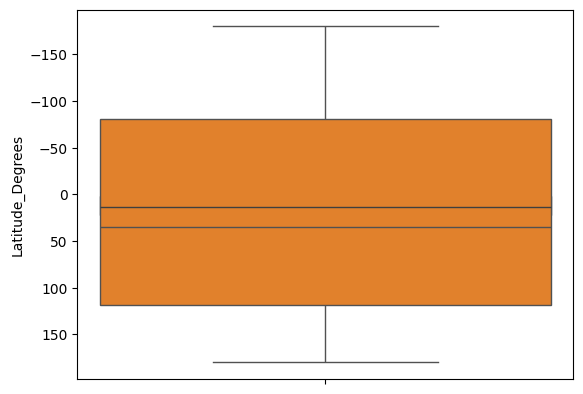

In [75]:
for i in range(len(num_fea)):
    sns.boxplot(dataset[num_fea[i]])


Cap outliers

In [13]:
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1 - 1.5 + IQR
    upper_bound = Q3 + 1.5 + IQR
    #mark outliers smaller than lower_bound or larger than upper_bound
    ls = df.index[ (df[ft] < lower_bound | df[ft] > upper_bound) ]

    return ls


In [26]:
#create emp list to store outliers indexes

index_ls = []
for feat in num_fea:
    index_ls.extend(outliers(dataset, feat))

TypeError: Cannot perform 'ror_' with a dtyped [float64] array and scalar of type [bool]

In [23]:
#handleoutliers z-score


outlier = []
def detect_outliers(data):
    threshold = 3
    

    for i in data:
        mean = np.mean(data[i]) 
        std = np.std(data[i])
        for j in data[i]:
         
            z = (j-mean)/std 
            if np.abs(z) > threshold: 
                outlier.append(j)
    return outlier


Store into a list

In [24]:

outlier_pt = detect_outliers(dataset.select_dtypes("number"))

In [30]:
outlier_pt

[51194.21,
 48474.24,
 92070.85,
 91552.84,
 143859.71,
 143859.71,
 54758.06,
 189086.68,
 65030.25,
 67195.55,
 131474.73,
 126026.15,
 71889.4,
 52976.19,
 72573.44,
 96083.57,
 80973.89,
 83077.86,
 89114.78,
 77683.58,
 79448.87,
 80356.74,
 73437.01,
 49301.53,
 50983.41,
 57331.18,
 93915.94,
 54310.79,
 205111.03,
 211205.33,
 51194.21,
 157756.93,
 111406.28,
 80208.51,
 162082.33,
 162082.33,
 91269.97,
 73851.0,
 162082.33,
 121393.87,
 91552.84,
 183108.82,
 171234.19,
 190899.82,
 148186.12,
 195281.21,
 84980.83,
 195281.21,
 89509.5,
 103028.51,
 53665.54,
 215472.85,
 215383.25,
 226662.83,
 228892.5,
 207155.02,
 219133.24,
 211334.72,
 222569.75,
 215384.77,
 281663.76,
 213577.89,
 214463.46,
 238898.44,
 233763.64,
 87781.32,
 75756.89,
 102340.43,
 104963.94,
 47965.2,
 60068.16,
 81377.72,
 85134.79,
 83316.53,
 56790.81,
 71593.3,
 59584.92,
 68964.81,
 50009.7,
 73130.33,
 61484.67,
 70373.13,
 72275.91,
 59819.69,
 56276.56,
 50029.14,
 52860.99,
 55114.55,
 55

In [29]:
dataset.drop(outlier_pt)

KeyError: '[51194.21, 48474.24, 92070.85, 91552.84, 143859.71, 143859.71, 54758.06, 189086.68, 65030.25, 67195.55, 131474.73, 126026.15, 71889.4, 52976.19, 72573.44, 96083.57, 80973.89, 83077.86, 89114.78, 77683.58, 79448.87, 80356.74, 73437.01, 49301.53, 50983.41, 57331.18, 93915.94, 54310.79, 205111.03, 211205.33, 51194.21, 157756.93, 111406.28, 80208.51, 162082.33, 162082.33, 91269.97, 73851.0, 162082.33, 121393.87, 91552.84, 183108.82, 171234.19, 190899.82, 148186.12, 195281.21, 84980.83, 195281.21, 89509.5, 103028.51, 53665.54, 215472.85, 215383.25, 226662.83, 228892.5, 207155.02, 219133.24, 211334.72, 222569.75, 215384.77, 281663.76, 213577.89, 214463.46, 238898.44, 233763.64, 87781.32, 75756.89, 102340.43, 104963.94, 47965.2, 60068.16, 81377.72, 85134.79, 83316.53, 56790.81, 71593.3, 59584.92, 68964.81, 50009.7, 73130.33, 61484.67, 70373.13, 72275.91, 59819.69, 56276.56, 50029.14, 52860.99, 55114.55, 55663.62, 65641.81, 189056.16, 70764.86, 156994.27, 58391.45, 66443.92, 80208.51, 90307.02, 182422.76, 95987.34, 182422.76, 188874.94, 183108.82, 190899.82, 162082.33, 124919.45, 97365.67, 97365.67, 148186.12, 128459.01, 128459.01, 82701.58, 136927.82, 212514.85, 215583.4, 218784.9, 225582.28, 195759.73, 230192.64, 116684.73, 202688.22, 122033.89, 122596.45, 230967.11, 119947.34, 235442.75, 215380.49, 233970.5, 73287.3, 57449.95, 136568.73, 136210.66, 169811.24, 57931.34, 118991.94, 118503.29, 77995.74, 139661.56, 87623.55, 87040.14, 88203.65, 91115.64, 94364.02, 107736.58, 110469.87, 109922.5, 87453.87, 105105.93, 86114.72, 94172.15, 70230.11, 65771.16, 72355.95, 74293.77, 63923.2, 62483.52, 70718.89, 69438.2, 60778.52, 58140.84, 66430.9, 82314.82, 53734.88, 93471.69, 88052.35, 91202.21, 68636.82, 67126.05, 50151.78, 61882.74, 56678.95, 50440.1, 49922.73, 91269.97, 55808.5, 53880.25, 59847.22, 60228.8, 69277.23, 71739.58, 72073.64, 81229.0, 84807.73, 83282.41, 79291.46, 80732.25, 73130.33, 58971.82, 71502.33, 76785.99, 67579.74, 54934.84, 78932.95, 66198.99, 78760.04, 82130.6, 90316.41, 66929.83, 56353.05, 63645.13, 56618.21, 299218.5, 54208.28, 96893.57, 195281.21, 190899.82, 186140.92, 71022.15, 124919.45, 70165.67, 70165.67, 68012.66, 68012.66, 58612.75, 71010.12, 143657.61, 66458.24, 80208.51, 52751.97, 47856.76, 189662.69, 191078.48, 122440.22, 145782.14, 192944.54, 57425.12, 57467.04, 57656.01, 144876.51, 144876.51, 149777.99, 63066.79, 61718.8, 56004.55, 52634.94, 49303.26, 49303.26, 64775.08, 64775.08, 64775.08, 147611.78, 146872.56, 147659.02, 148458.97, 148990.19, 146399.14, 149083.67, 149653.18, 149110.09, 148972.42, 147287.72, 87712.94, 87712.94, 96675.28, 96675.28, 96675.28, 96675.28, 96675.28, 96675.28, 96675.28, 96675.28, 98814.66, 99294.93, 51904.73, 61863.4, 61863.4, 78213.95, 76793.74, 64539.0, 70110.13, 63298.44, 63298.44, 63298.44, 111762.34, 62032.23, 49210.25, 49210.25, 144876.51, 149777.99, 49210.25, 149777.99, 144876.51, 149777.99, 58349.93, 56186.83, 57761.46, 57761.46, 56186.83, 57425.12, 149777.99, 61718.8, 64775.08, 49210.25, 56021.28, 58349.93, 57425.12, 63066.79, 56186.83, 57761.46, 57761.46, 58349.93, 63066.79, 63066.79, 57761.46, 53198.14, 63066.79, 57761.46, 47718.11, 48230.72, 148083.17, 57761.46, 51843.91, 149154.63, 86014.44, 57761.46, 61718.8, 150705.93, 63066.79, 146925.88, 57761.46, 89526.3, 58103.71, 62196.2, 79959.38, 90492.16, 90583.82, 49086.13, 49250.54, 57761.46, 49173.46, 47692.8, 55849.66, 47692.8, 148105.69, 147478.78, 149154.63, 63066.79, 63066.79, 144745.51, 47718.11, 84816.63, 48601.45, 49036.67, 49036.67, 48877.66, 48877.66, 51699.9, 51040.61, 50202.47, 50202.47, 144745.51, 144745.51, 144745.51, 144876.51, 144876.51, 149001.83, 149001.83, 149777.99, 150705.93, 147958.43, 67968.29, 69021.92, 69021.92, 69324.37, 69324.37, 69324.37, 69396.42, 60841.69, 60841.69, 96675.28, 96675.28, 98814.66, 98814.66, 75072.6, 75072.6, 75321.76, 75321.76, 71137.54, 71137.54, 57753.52, 53599.0, 67950.77, 203507.86, 192712.08, 192712.08, 0.2584, 0.2687, 0.4058, 0.3917, 0.2687, 0.3326, 0.2744, 0.2677, 0.2594, 0.2594, 0.256, 0.4564, 0.2724, 0.2565, 0.3008, 0.2531, 0.6108, 0.2815, 0.3437, 0.4373, 0.4373, 0.7188, 0.2815, 0.2574, 0.2815, 0.2815, 0.2815, 0.4569, 0.259, 0.2815, 0.308, 0.2815, 1.2845, 0.2636, 0.2733, 0.2574, 0.3092, 0.3196, 0.2711, 0.3844, 0.9785, 0.5804, 0.3698, 0.5143, 0.3012, 0.3083, 0.3064, 0.5074, 0.431, 0.4222, 0.2574, 0.2574, 0.2574, 0.2574, 0.2574, 0.2574, 0.2574, 0.2574, 0.259, 0.2574, 0.2574, 0.7188, 0.4293, 0.2859, 0.259, 0.7188, 0.2506, 0.2757, 0.5246, 0.2594, 0.2594, 0.2594, 0.2574, 0.2574, 0.2685, 0.8039, 0.2763, 0.2763, 0.4293, 0.3697, 1.1434, 0.2774, 0.2792, 0.3879, 0.327, 0.327, 0.286, 0.3382, 0.5181, 0.2574, 0.8455, 0.4388, 0.4293, 0.4293, 0.4293, 0.3644, 0.7188, 0.2815, 0.2787, 0.2787, 0.263, 0.2787, 0.2725, 0.2607, 0.2607, 0.2607, 0.2607, 0.2824, 0.2824, 0.2824, 0.2824, 0.2774, 0.2774, 0.2774, 0.2774, 0.2774, 0.2774, 0.2774, 0.2543, 0.2543, 0.2543, 0.2543, 0.2543, 0.2543, 0.2543, 0.3187, 0.3187, 0.3187, 0.3187, 0.3187, 0.3187, 0.2801, 0.2801, 0.2801, 0.2801, 0.2801, 0.2801, 0.2801, 0.2801, 0.2825, 0.3318, 0.3318, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.3318, 0.3318, 0.3318, 0.3318, 0.33, 0.33, 0.33, 0.33, 0.33, 0.4006, 0.4006, 0.4006, 0.4006, 0.2824, 0.2824, 0.2824, 0.2824, 0.2824, 0.2824, 0.2774, 0.2774, 0.2774, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2511, 0.2506, 0.2506, 0.2506, 0.2506, 0.2506, 0.2543, 0.2825, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2932, 0.2813, 0.2932, 0.2932, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.3318, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.2825, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4006, 0.4658, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.3266, 0.2751, 0.2669, 0.3431, 0.3431, 0.2861, 0.2625, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2899, 0.2563, 0.2563, 0.2563, 0.2563, 0.2563, 0.2563, 0.2563, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.4293, 0.2681, 0.2899, 0.2899, 0.2899, 0.4293, 0.271, 0.271, 0.271, 0.271, 0.271, 0.271, 0.271, 0.2617, 0.2617, 0.2617, 0.2617, 0.2617, 0.2617, 0.2821, 0.2821, 0.2821, 0.2821, 0.2821, 0.2821, 0.358, 0.358, 0.4134, 0.4134, 0.3632, 0.3104, 0.3104, 0.2626, 0.2626, 0.3447, 0.3447, 0.2534, 0.2534, 0.264, 0.264, 0.264, 0.264, 0.264, 0.4387, 0.4387, 0.4387, 0.4387, 0.4387, 0.4387, 0.4138, 1.1635, 1.1635, 1.1635, 0.3208, 0.2637, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.3008, 0.2568, 0.3066, 0.301, 0.271, 0.271, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.33, 0.2825, 0.2932, 0.2543, 0.256, 0.251, 0.2787, 0.2787, 0.2787, 0.2787, 0.2506, 0.4006, 0.271, 0.2617, 0.2637, 0.3008, 0.2825, 0.2825, 0.2543, 0.251, 0.3302, 0.3187, 0.2506, 0.33, 0.2617, 0.2617, 0.4387, 1.1635, 0.2787, 0.2825, 0.2825, 0.4387, 0.251, 0.2787, 0.3187, 0.3318, 0.2914, 0.3008, 0.2787, 0.2787, 0.263, 0.251, 0.2725, 0.2824, 0.2506, 0.2825, 0.3318, 0.2825, 0.2986, 0.2932, 0.2506, 0.2932, 0.3187, 0.256, 0.251, 0.2932, 0.2617, 0.3008, 0.2774, 0.33, 0.2751, 0.2681, 0.2815, 0.251, 0.2787, 0.2824, 0.2825, 0.2637, 0.4408, 0.2801, 0.2506, 0.2617, 0.251, 0.251, 0.3302, 0.3187, 0.2506, 0.2932, 0.2825, 0.4006, 0.4293, 0.251, 0.2787, 0.2932, 0.251, 0.2787, 0.2787, 0.2852, 0.2932, 0.3246, 0.4321, 0.4293, 0.4293, 0.2815, 0.4293, 0.3318, 0.256, 0.251, 0.2932, 0.251, 0.2787, 0.3318, 0.256, 0.263, 0.3318, 0.2824, 0.3318, 0.256, 0.3294, 0.2815, 0.2815, 0.2787, 0.2787, 0.3246, 0.256, 0.251, 0.251, 0.3246, 0.3246, 0.4293, 0.251, 0.251, 0.3326, 0.256, 0.256, 0.2824, 0.2774, 0.2774, 0.2774, 0.2774, 0.2506, 0.2543, 0.2932, 0.3187, 0.3187, 0.3187, 0.2801, 0.2825, 0.3318, 0.2825, 0.2825, 0.2825, 0.3318, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.4006, 0.4006, 0.256, 0.256, 0.256, 0.256, 0.256, 0.3066, 85.57, 85.57, 85.57, 85.57, 19.86, 19.86, 92.3, 88.72, 88.72, 85.57, 82.57, 88.72, 88.08, 88.72, 88.72, 92.3, 26.33, 88.72, 82.57, 88.72, 82.57, 82.57, 82.57, 88.72, 82.57, 85.57, 85.57, 85.57, 85.57, 85.57, 82.57, 88.72, 85.57, 82.57, 21.71, 21.71, 99.43, 26.33, 77.11, 77.11, 81.3, 85.57, 77.61, 77.61, 77.11, 77.11, 77.11, 77.11, 77.11, 77.11, 77.11, 77.11, 94.95, 26.5, 26.5, 85.57, 83.24, 81.37, 82.57, 85.57, 85.57, 19.86, 19.86, 86.91, 18.31, 21.8, 80.68, 21.71, 84.24, 19.86, 77.11, 94.95, 78.86, 77.11, 77.11, 94.95, 94.95, 94.95, 94.95, 78.86, 105.8, 25.13, 99.43, 99.43, 81.37, 81.37, 81.37, 81.37, 81.37, 99.43, 79.45, 81.37, 81.37, 99.43, 81.37, 81.37, 82.57, 88.08, 81.37, 81.37, 81.37, 81.37, 83.24, 79.45, 79.45, 85.66, 102.37, 80.68, 80.23, 80.23, 25.9, 25.3, 25.3, 25.9, 25.9, 80.04, 79.45, 81.37, 81.37, 77.61, 77.11, 94.95, 26.03, 88.72, 88.72, 87.59, 86.05, 81.37, 19.86, 19.86, 26.57, 85.57, 85.57, 88.72, 88.72, 88.08, 88.72, 19.86, 77.14, 77.14, 77.14, 77.14, 77.14, 77.14, 77.14, 92.3, 92.3, 92.3, 92.3, 92.3, 92.3, 92.3, 77.61, 77.61, 77.61, 77.61, 77.61, 77.61, 26.03, 26.03, 25.23, 25.23, 85.57, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 88.08, 84.57, 84.57, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 77.14, 92.3, 86.19, 92.3, 92.3, 92.3, 81.37, 19.86, 92.3, 92.3, 85.57, 81.37, 19.86, 85.57, 92.3, 88.08, 88.08, 92.3, 88.08, 19.86, 19.86, 88.08, 88.08, 88.08, 88.08, 88.08, 86.19, 88.08, 91.11, 91.11, 91.11, 91.11, 91.11, 91.11, 88.08, 19.86, 77.14, 88.08, 88.08, 92.3, 88.08, 88.08, 88.08, 88.08, 88.08, 79.45, 79.45, 92.3, 99.22, 79.45, 79.45, 79.45, 79.45, 79.45, 79.45, 92.3, 88.08, 88.08, 88.08, 88.08, 19.86, 19.86, 88.08, 88.08, 81.3, 81.3, 81.37, 81.37, 92.3, 88.08, 88.08, 88.08, 88.08, 81.37, 88.08, 88.08, 85.57, 88.08, 99.22, 19.86, 92.3, 92.3, 92.3, 81.37, 81.37, 88.08, 88.08, 85.57, 88.08, 88.08, 23.07, 92.3, 92.3, 92.3, 26.44, 26.44, 26.44, 26.44, 26.44, 26.44, 27.39, 85.57, 86.05, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 81.37, 19.86, 25.94, 19.86, 77.61, 77.61, 77.61, 77.61, 77.61, 77.61, 77.61, 77.61, 77.61, 25.5, 81.3, 81.3, 81.3, 81.3, 81.3, 81.3, 26.91, 26.91, 26.91, 26.91, 82.57, 85.57, 85.57, 85.57, 85.57, 85.57, 85.57, 85.57, 25.23, 88.08, 88.08, 88.08, 88.08, 93.75, 98.75, 92.5, 92.5, 92.5, 93.12, 97.5, 92.5, 82.29, 82.3, 82.3, 82.35, 82.4, 82.5, 82.5, 82.7, 83.1, 83.2, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.3, 83.33, 83.33, 83.33, 83.33, 83.33, 83.5, 83.85, 83.9, 83.9, 84.1, 84.3, 84.9, 85.1, 85.3, 85.5, 85.7, 85.7, 85.7, 85.7, 85.7, 85.7, 85.7, 85.7, 85.71, 85.71, 85.71, 85.9, 86.7, 86.7, 86.8, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87.8, 87.9, 88.2, 88.2, 88.2, 88.2, 88.24, 88.46, 88.5, 88.6, 88.7, 88.8, 88.8, 88.89, 88.9, 88.9, 88.9, 88.9, 88.9, 88.9, 88.9, 88.9, 88.9, 89.2, 89.26, 89.5, 89.5, 90.2, 90.2, 90.5, 90.9, 91.5, 91.7, 91.7, 91.7, 91.8, 92.1, 92.2, 92.5, 92.6, 92.9, 93.2, 93.6, 93.8, 93.8, 93.9, 94.2, 94.4, 95.5, 95.6, 95.6, 95.7, 95.8, 96.2, 96.2, 96.5, 96.7, 97.02, 97.5, 97.5, 98.3, 98.4, 98.5, 98.5, 98.8, 82.04, 82.15, 82.26, 82.27, 82.5, 82.5, 82.86, 83.33, 83.81, 83.91, 83.98, 84.16, 84.93, 85.05, 85.16, 85.28, 85.3, 85.95, 86.01, 86.21, 86.36, 86.67, 86.78, 87.01, 87.14, 87.5, 87.5, 87.67, 87.68, 87.89, 88.06, 88.11, 88.75, 89.07, 89.22, 89.44, 89.48, 89.71, 90.15, 90.2, 90.25, 90.35, 90.41, 90.43, 90.7, 90.93, 90.95, 90.97, 91.53, 91.6, 91.67, 91.84, 92.31, 92.5, 92.63, 92.73, 92.73, 92.88, 93.22, 93.33, 93.45, 93.94, 94.44, 94.72, 95.24, 95.5, 96.46, 96.5, 97.22, 290.1, 294.68, 309.71, 310.44, 309.82, 309.99, 307.76, 307.66, 307.25, 310.26, 309.76, 289.66, 287.63, 289.53, 287.73, 289.53, 293.66, 289.53, 288.26, 287.76, 287.18, 294.59, 294.68, 288.83, 294.83, 294.02, 293.91, 294.18, 294.64, 295.19, 293.91, 295.24, 295.24, 294.78, 294.48, 295.14, 294.37, 292.19, 293.7, 292.24, 294.54, 292.4, 294.09, 287.04, 293.95, 293.89, 293.97, 293.89, 291.76, 293.02, 295.13, 295.13, 294.05, 295.35, 295.35, 295.35, 289.32, 295.35, 291.07, 309.2, 292.7, 294.95, 294.12, 294.52, 294.51, 295.48, 295.47, 292.64, 294.12, 294.41, 294.12, 295.33, 294.74, 295.47, 294.64, 294.35, 294.35, 294.35, 294.12, 308.81, 308.14, 307.36, 295.08, 294.99, 294.56, 295.07, 295.18, 293.2, 293.9, 294.91, 295.41, 293.26, 293.14, 292.59, 294.69, 293.39, 292.4, 294.6, 294.46, 294.95, 295.12, 294.95, 294.46, 294.52, 295.36, 295.49, 291.64, 294.2, 294.2, 293.53, 292.03, 292.32, 293.46, 293.59, 292.72, 295.49, 294.82, 291.94, 294.39, 295.16, 295.16, 295.25, 295.44, 295.44, 295.44, 295.44, 295.16, 295.52, 295.52, 294.88, 295.46, 295.46, 295.05, 295.05, 294.72, 294.72, 294.72, 294.72, 295.39, 295.43, 294.57, 295.07, 295.16, 293.85, 295.16, 295.35, 294.07, 295.26, 294.07, 295.02, 295.22, 295.22, 294.86, 295.13, 295.13, 293.94, 293.94, 293.94, 294.94, 293.72, 295.02, 295.02, 295.27, 295.02, 295.44, 295.27, 295.02, 295.44, 295.44, 295.44, 294.39, 294.83, 295.3, 295.3, 295.21, 293.45, 295.47, 295.47, 295.47, 295.23, 295.23, 295.23, 295.25, 295.26, 294.92, 294.67, 294.67, 295.46, 294.51, 294.51, 294.58, 294.58, 295.32, 295.32, 294.47, 294.99, 295.4, 295.4, 294.99, 294.56, 294.89, 294.89, 294.39, 294.39, 294.56, 295.4, 293.14, 294.44, 295.14, 295.14, 295.02, 294.49, 294.49, 295.23, 295.02, 295.38, 295.38, 294.22, 292.28, 292.19, 293.56, 293.39, 293.72, 294.57, 295.46, 294.47, 294.73, 294.1, 294.94, 293.26, 293.53, 294.19, 295.36, 293.85, 295.3, 295.12, 294.52, 292.86, 292.82, 293.39, 292.82, 294.93, 294.73, 295.02, 295.3, 294.39, 292.28, 293.59, 293.2, 292.92, 292.54, 295.37, 292.66, 295.35, 293.82, 292.35, 293.41, 294.87, 294.87, 293.92, 294.39, 295.08, 294.6, 292.39, 294.44, 295.33, 295.37, 293.21, 295.25, 295.33, 294.52, 294.14, 293.85, 295.37, 295.5, 294.82, 295.5, 295.37, 294.92, 292.72, 295.5, 295.29, 294.92, 295.37, 295.37, 294.14, 293.85, 294.9, 294.83, 295.44, 295.5, 292.58, 295.5, 295.5, 295.44, 293.63, 295.1, 295.1, 294.85, 295.37, 293.85, 293.85, 294.6, 295.39, 295.37, 293.16, 293.16, 294.98, 295.1, 292.8, 295.18, 295.18, 293.39, 294.85, 294.85, 295.48, 295.48, 293.72, 295.08, 294.51, 295.5, 293.6, 293.42, 293.42, 292.09, 292.09, 295.44, 293.53, 293.46, 294.39, 307.62, 307.62, 308.19, 309.06, 308.19, 309.06, 295.31, 295.31, 295.31, 295.31, 295.17, 295.3, 295.25, 295.25, 295.26, 307.64, 307.64, 294.37, 294.37, 294.98, 294.98, 295.41, 295.41, 295.41, 295.36, 295.51, 295.14, 295.14, 294.67, 294.77, 294.55, 295.21, 295.22, 295.18, 294.98, 294.98, 294.82, 295.36, 294.82, 294.68, 294.39, 294.39, 294.33, 295.23, 295.32, 295.32, 295.56, 292.96, 292.96, 295.5, 295.73, 295.39, 295.24, 295.36, 293.07, 293.66, 290.94, 295.24, 295.46, 293.57, 293.48, 295.26, 295.25, 295.18, 294.75, 294.5, 294.5, 294.5, 294.5, 292.28, 293.35, 293.03, 293.03, 292.91, 292.91, 292.91, 292.91, 292.91, 292.91, 292.91, 292.91, 292.81, 292.81, 292.81, 292.81, 292.85, 292.85, 292.85, 292.74, 292.84, 292.84, 292.74, 292.58, 292.58, 292.49, 292.49, 292.49, 292.44, 292.44, 292.43, 291.38, 293.98, 292.85, 293.47, 293.19, 292.83, 292.83, 292.83, 295.22, 294.33, 295.01, 293.98, 293.98, 293.96, 293.91, 293.91, 294.06, 293.44, 293.51, 293.54, 295.46, 293.96, 293.96, 293.24, 295.44, 295.07, 294.71, 292.29, 292.29, 294.75, 294.57, 294.58, 294.58, 294.58, 294.58, 295.16, 295.02, 293.62, 293.49, 293.65, 294.71, 294.71, 294.42, 294.42, 290.88, 293.9, 293.23, 293.23, 293.54, 293.54, 293.54, 293.54, 293.19, 293.19, 293.19, 293.18, 293.19, 292.93, 292.28, 293.08, 293.12, 293.12, 293.12, 293.12, 293.12, 293.12, 293.12, 293.14, 293.03, 293.03, 292.59, 292.78, 292.84, 292.91, 292.58, 295.39, 295.39, 295.56, 295.24, 295.24, 295.24, 295.24, 295.25, 295.18, 295.2, 294.75, 294.75, 294.5, 294.5, 293.13, 295.39, 295.39, 293.75, 295.46, 294.63, 294.44, 292.63, 292.69, 293.5, 294.71, 294.71, 293.04, 292.73, 293.19, 293.13, 295.39, 295.24, 295.25, 295.25, 295.25, 295.18, 295.18, 292.91, 292.91, 292.91, 293.54, 293.13, 293.54, 293.96, 295.42, 295.25, 294.3, 294.3, 293.65, 294.71, 294.56, 293.9, 293.9, 293.12, 294.76, 295.73, 294.31, 294.31, 294.42, 294.42, 295.62, 295.62, 295.62, 295.62, 295.62, 295.62, 295.62, 295.62, 294.71, 294.56, 294.5, 294.5, 294.5, 294.5, 294.5, 294.5, 294.3, 294.3, 294.3, 294.3, 294.3, 294.3, 294.3, 294.3, 294.71, 294.71, 294.71, 294.56, 294.56, 294.56, 294.56, 294.56, 294.71, 294.56, 294.3, 295.78, 294.71, 294.3, 295.01, 295.73, 294.71, 295.78, 295.77, 295.17, 295.17, 295.24, 295.24, 294.31, 294.42, 295.45, 295.62, 295.62, 295.62, 295.62, 295.62, 295.62, 294.71, 294.71, 294.56, 294.56, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 293.03, 286.89, 287.73, 287.27, 287.27, 287.51, 287.36, 287.51, 287.73, 287.51, 287.41, 287.75, 286.85, 285.64, 285.58, 280.59, 286.02, 287.01, 286.85, 285.92, 285.54, 287.08, 286.85, 286.73, 286.69, 285.13, 285.13, 285.13, 285.13, 284.64, 285.57, 285.17, 285.17, 284.95, 284.95, 284.95, 284.95, 284.95, 284.95, 284.95, 284.95, 285.21, 285.21, 285.21, 285.21, 285.13, 285.13, 285.13, 284.1, 285.59, 285.59, 285.61, 284.57, 284.32, 285.1, 285.1, 285.1, 285.44, 285.44, 285.19, 282.07, 286.56, 285.13, 286.57, 285.51, 284.97, 284.97, 284.97, 286.08, 286.07, 286.56, 286.56, 285.91, 286.05, 286.05, 286.23, 284.76, 284.85, 285.03, 286.58, 286.58, 284.79, 286.98, 286.33, 284.58, 284.58, 286.69, 285.98, 285.99, 285.99, 285.99, 285.99, 287.23, 287.02, 285.8, 283.84, 283.18, 286.76, 286.76, 286.29, 286.29, 282.2, 285.79, 285.8, 285.8, 285.23, 285.23, 285.23, 285.23, 285.51, 285.51, 285.51, 285.51, 285.51, 285.57, 283.54, 285.19, 285.27, 285.27, 285.27, 285.27, 285.27, 285.27, 285.27, 285.06, 285.17, 285.17, 283.45, 284.1, 285.59, 285.61, 284.32, 287.75, 287.75, 285.51, 286.85, 286.85, 286.85, 286.85, 286.85, 286.73, 286.73, 286.69, 286.69, 285.13, 285.13, 285.41, 287.75, 287.75, 286.02, 286.82, 285.22, 284.07, 284.02, 286.05, 286.76, 286.76, 283.42, 283.98, 285.51, 285.41, 286.07, 285.62, 287.75, 286.85, 286.85, 286.85, 286.85, 286.73, 286.73, 284.95, 284.95, 284.95, 285.23, 285.41, 285.03, 286.58, 287.19, 286.85, 285.39, 285.39, 283.18, 286.76, 286.47, 285.79, 285.79, 285.27, 286.81, 287.13, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.85, 284.85, 284.85, 284.85, 284.85, 284.85, 284.85, 285.96, 285.96, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 284.68, 284.68, 284.68, 284.68, 284.85, 284.85, 284.85, 285.26, 285.26, 285.26, 285.26, 285.26, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.68, 284.85, 285.26, 285.26, 285.26, 284.68, 284.68, 284.68, 284.68, 284.82, 284.82, 284.82, 284.82, 284.82, 284.82, 284.82, 284.68, 284.68, 284.68, 284.85, 284.85, 284.85, 285.26, 284.68, 284.68, 284.68, 284.68, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.26, 285.96, 285.96, 285.96, 285.96, 285.96, 285.96, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 286.75, 287.73, 287.73, 287.73, 287.73, 287.73, 287.73, 286.34, 286.34, 285.77, 285.77, 285.85, 285.85, 285.85, 285.85, 285.85, 285.85, 285.85, 285.85, 286.76, 286.47, 285.13, 285.13, 285.13, 285.13, 285.13, 285.13, 285.39, 285.39, 285.39, 285.39, 285.39, 285.39, 285.39, 285.39, 286.76, 286.76, 286.76, 286.47, 286.47, 286.47, 286.47, 286.47, 287.67, 287.64, 284.85, 286.76, 286.47, 287.07, 284.85, 284.68, 285.26, 284.68, 285.39, 286.47, 284.85, 287.07, 285.26, 286.76, 286.47, 285.39, 287.07, 284.68, 286.75, 286.75, 284.54, 285.26, 284.82, 285.26, 287.07, 285.26, 287.07, 287.07, 284.68, 287.07, 284.54, 286.76, 284.54, 285.26, 287.07, 285.26, 284.68, 284.68, 285.26, 285.26, 287.07, 287.07, 287.07, 287.07, 285.26, 284.54, 287.57, 287.57, 287.57, 287.44, 287.44, 287.44, 287.44, 287.44, 287.51, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.54, 284.68, 284.68, 284.68, 284.68, 285.26, 284.85, 284.85, 284.68, 285.26, 285.96, 287.07, 287.07, 287.07, 287.07, 287.07, 287.07, 286.85, 286.85, 286.34, 285.77, 287.48, 285.85, 285.85, 285.85, 285.85, 285.85, 285.85, 286.76, 286.76, 286.47, 286.47, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 285.17, 286.38, 286.38, 287.29, 287.29, 310.77, 310.32, 310.05, 309.27, 310.6, 310.62, 310.72, 309.84, 300.96, 311.08, 300.38, 300.38, 310.26, 310.54, 310.61, 310.72, 309.5, 309.64, 310.26, 310.44, 309.95, 310.57, 300.13, 311.14, 310.11, 309.86, 309.5, 309.64, 309.64, 313.14, 313.14, 313.14, 301.22, 300.48, 301.04, 301.17, 312.76, 311.1, 309.26, 300.96, 309.11, 310.06, 311.04, 313.14, 313.14, 311.6, 310.57, 309.22, 309.6, 309.6, 313.14, 311.1, 311.1, 310.57, 310.57, 309.5, 310.11, 309.56, 313.14, 309.52, 309.52, 309.92, 310.5, 313.14, 311.08, 309.35, 309.38, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.32, 310.32, 310.32, 310.32, 313.14, 313.14, 313.14, 309.07, 309.07, 309.07, 309.07, 309.07, 309.62, 309.44, 309.44, 309.89, 310.04, 309.55, 309.02, 309.35, 309.35, 309.35, 309.35, 309.35, 311.08, 311.01, 313.14, 310.42, 310.42, 310.91, 310.91, 310.91, 310.91, 309.48, 311.13, 310.04, 310.04, 310.04, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 311.16, 311.16, 311.16, 311.16, 311.16, 311.16, 311.16, 313.14, 310.38, 310.38, 310.38, 310.38, 310.38, 310.38, 310.38, 310.38, 310.38, 310.38, 309.01, 309.01, 309.01, 309.01, 309.55, 313.14, 313.14, 313.14, 309.84, 310.92, 309.35, 309.35, 310.92, 310.32, 313.14, 309.55, 309.55, 311.01, 311.01, 310.78, 311.01, 311.01, 313.14, 301.25, 311.08, 311.13, 311.01, 310.92, 310.92, 313.14, 309.35, 311.01, 311.01, 310.92, 311.08, 311.08, 310.78, 310.04, 311.01, 311.01, 311.01, 309.75, 310.92, 309.35, 311.01, 311.13, 311.01, 311.01, 310.92, 310.59, 311.01, 309.02, 309.02, 310.92, 311.01, 310.92, 311.13, 309.35, 311.01, 310.92, 311.01, 310.92, 310.92, 310.92, 311.01, 310.59, 309.84, 301.29, 311.44, 311.44, 311.44, 309.95, 309.95, 309.95, 309.95, 309.95, 310.59, 309.37, 309.37, 309.37, 309.37, 309.37, 309.37, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.92, 310.32, 310.32, 310.32, 310.32, 310.32, 309.76, 309.44, 309.72, 309.72, 309.55, 309.55, 309.16, 309.16, 309.16, 309.16, 309.16, 311.08, 311.08, 311.08, 311.08, 311.08, 311.08, 311.08, 311.08, 311.08, 311.08, 309.83, 309.92, 310.37, 310.37, 310.38, 310.38, 311.01, 311.01, 311.01, 311.01, 311.01, 311.01, 301.18, 5.06, 4.24, 4.83, 5.93, 5.77, 4.99, 5.9, 5.9, 5.86, 5.95, 5.9, 5.77, 4.67, 5.86, 5.71, 5.43, 4.17, 4.41, 4.33, 5.95, 6.08, 5.44, 4.97, 4.49, 4.16, 4.16, 5.36, 5.35, 4.72, 4.37, 4.49, 4.08, 4.01, 4.01, 4.01, 4.01, 4.65, 3.89, 4.3, 4.3, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 4.31, 3.96, 3.96, 3.96, 3.96, 4.31, 4.31, 4.31, 4.31, 4.31, 3.96, 4.14, 4.14, 4.1, 4.18, 4.02, 3.98, 3.98, 3.98, 3.96, 3.96, 4.03, 5.41, 4.21, 3.87, 4.11, 4.15, 3.9, 4.21, 4.21, 4.32, 4.35, 4.35, 4.37, 4.42, 4.48, 4.42, 3.88, 3.91, 4.2, 4.55, 4.55, 4.08, 3.97, 3.97, 3.97, 3.97, 3.97, 4.07, 4.38, 4.34, 4.95, 4.07, 4.07, 3.9, 3.9, 3.9, 3.9, 4.11, 4.11, 4.11, 4.1, 4.11, 3.98, 4.52, 4.28, 3.89, 3.89, 3.89, 3.89, 3.89, 3.89, 3.89, 3.93, 4.3, 4.3, 4.77, 3.93, 4.14, 4.04, 4.02, 5.02, 5.02, 4.08, 4.08, 4.01, 4.01, 4.19, 4.43, 3.97, 4.6, 4.58, 4.1, 4.6, 4.64, 4.11, 4.19, 5.75, 4.85, 4.93, 3.94, 3.94, 3.94, 3.9, 4.19, 4.42, 3.94, 3.94, 4.34, 3.89, 5.27, 4.67, 4.86, 4.39, 4.59, 4.43, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.01, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.1, 4.1, 4.1, 4.1, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.25, 4.25, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.16, 4.16, 4.16, 4.16, 4.16, 4.16, 4.16, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.09, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.21, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.08, 4.05, 4.05, 4.21, 4.2, 4.22, 3.91, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 4.5, 4.5, 4.39, 4.39, 4.42, 4.36, 4.79, 4.79, 4.99, 4.09, 4.2, 4.24, 4.26, 4.2, 4.2, 4.21, 4.2, 4.25, 4.5, 4.5, 3.94, 5.82, 4.22, 4.22, 4.2, 4.26, 4.21, 4.09, 5.82, 4.24, 4.24, 3.94, 4.26, 4.1, 4.2, 4.21, 4.21, 4.24, 4.24, 4.2, 4.21, 4.16, 4.22, 4.16, 4.24, 4.21, 4.26, 4.21, 4.26, 4.26, 4.2, 4.26, 4.24, 4.24, 4.21, 4.09, 4.2, 4.24, 4.22, 4.21, 3.91, 3.95, 4.26, 4.21, 4.2, 4.2, 4.22, 4.22, 4.26, 4.24, 4.25, 4.26, 4.26, 4.1, 4.26, 4.22, 4.1, 4.1, 4.2, 4.1, 4.99, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.92, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.21, 4.2, 4.2, 4.2, 4.22, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.1, 4.1, 4.1, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.05, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.29, 4.29, 4.5, 4.5, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 5.92, 6.08, 6.08, 4.81, 4.81, 3.56, 3.43, 4.05, 4.05, 3.41, 5.48, 3.26, 3.83, 3.4, 5.14, 4.48, 4.09, 4.44, 4.45, 3.77, 3.03, 4.56, 4.28, 3.73, 3.73, 2.99, 3.43, 4.06, 2.89, -2.45, 4.22, 3.12, 2.86, 4.08, 4.08, -4.0, 2.86, -2.61, 3.44, -2.45, -2.45, -2.45, -2.45, 3.8, 2.88, 4.74, 2.83, 2.88, 4.67, 4.67, 2.9, 3.15, 3.16, 3.09, 3.36, 4.39, 4.16, 4.05, 2.91, 4.25, 3.48, 3.71, -2.28, 4.08, -3.64, 4.12, 4.74, -3.47, 4.03, 2.83, 3.48, 3.54, -3.22, 3.05, -2.94, 3.53, -3.35, 3.31, 3.1, 4.74, 4.74, 4.74, 4.03, 4.08, -2.66, -2.66, -2.66, -2.69, 3.28, -4.62, 4.61, -2.3, 2.99, -2.84, -2.89, -3.5, 2.99, -2.65, -2.73, -2.73, -2.73, -2.64, -2.64, -2.35, 3.2, 2.84, -3.86, -3.35, -3.35, -3.35, -2.38, -2.38, 3.14, 3.14, 3.14, 3.14, -2.83, -2.83, -2.54, -2.54, -2.42, -2.3, 2.96, 3.29, 2.96, 2.96, 4.23, 4.23, 4.23, -3.62, -3.65, -3.88, 3.76, -2.82, 2.98, -2.96, -3.7, -3.42, -2.55, 2.98, -3.25, 3.29, 3.29, -2.37, -2.3, -2.83, -4.26, -2.83, 3.35, -2.3, 4.8, 4.61, -2.52, -3.78, 2.97, 3.94, -3.65, 4.04, 4.8, 3.94, -2.96, 4.2, -2.88, 4.84, -4.05, -3.39, 3.94, -2.88, 5.1, 5.9, 2.94, 4.02, 3.03, 4.82, 4.13, -3.05, 4.08, 4.02, 5.1, 2.83, 2.93, 4.29, 4.29, 3.35, 4.38, 3.31, 3.69, 3.4, 2.85, 3.15, -3.06, 3.37, 3.76, -3.06, 3.31, 2.88, 4.04, 3.37, 4.82, -3.14, 5.4, 4.45, 3.91, 5.1, -2.81, 4.02, 2.83, 2.93, 3.31, -2.81, 3.91, -3.27, 3.43, 3.91, -3.27, 3.91, -3.05, 3.4, 3.02, 4.92, 3.56, 4.92, 5.05, 4.83, 2.96, 3.11, 3.43, 3.02, 3.04, 5.05, 5.05, 3.04, 3.91, 3.31, 3.31, 3.04, 2.82, 3.04, -2.49, 3.91, 3.13, 3.52, 3.17, 3.17, -2.29, 2.84, 2.84, 3.19, 3.19, -3.6, -3.6, -3.05, -3.05, -2.66, -2.66, 3.88, 3.88, 3.88, 2.47, 1.77, 1.94, 1.77, 2.58, 2.58, 2.58, 2.23, 2.23, 2.23, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.17, 2.17, 1.62, 2.23, 2.23, 2.63, 2.63, 2.63, 2.63, 2.63, 1.77, 1.77, 1.99, 1.99, 1.99, 1.99, 1.64, 1.64, 1.64, 1.64, 1.77, 1.77, 1.77, 1.77, 1.77, 1.77, 1.92, 1.77, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 1.64, 2.51, 2.51, 2.52, 2.52, 2.51, 2.52, 2.51, 2.51, 2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.61, 2.58, 2.58, 2.58, 2.52, 2.52, 2.58, 2.52, 2.52, 2.61, 2.57, 2.57, 2.57, 2.83, 2.83, 2.51, 2.5, 2.5, 2.52, 2.52, 2.52, 2.52, 2.52, 2.58, 2.58, 2.48, 2.23, 2.23, 2.23, 2.23, 2.63, 1.64, 2.52, 2.52, 2.52, 2.61, 2.61, 2.52, 2.23, 2.63, 2.63, 2.58, 2.52, 2.61, 2.61, 2.61, 2.61, 2.61, 2.61, 2.23, 2.63, 2.63, 1.99, 2.58, 2.61, 2.61, 2.52, 2.23, 1.76, 2.61, 2.61, 2.61, 2.63, 2.52, 2.62, 2.62, 2.62, 2.62, 2.62, 2.23, 2.61, 2.58, 2.23, 2.57, 2.57, 2.61, 2.61, 2.58, 2.61, 2.58, 2.52, 2.58, 2.61, 2.61, 2.58, 2.57, 2.58, 2.42, 2.57, 2.58, 2.52, 2.48, 2.61, 2.62, 2.62, 2.62, 2.62, 2.62, 2.62, 2.61, 2.61, 1.64, 2.58, 2.52, 2.58, 2.61, 1.62, 2.57, 2.57, 2.52, 2.61, 2.57, 2.61, 2.79, 1.99, 2.58, 2.58, 2.61, 2.42, 2.79, 2.61, 2.52, 2.54, 2.54, 2.61, 2.57, 2.52, 2.61, 2.61, 1.99, 2.61, 2.57, 2.58, 2.61, 2.79, 2.63, 1.99, 1.99, 2.52, 2.57, 2.61, 2.83, 2.23, 2.52, 2.61, 2.61, 2.57, 2.61, 2.58, 2.58, 2.58, 2.57, 2.23, 2.52, 2.58, 2.52, 2.58, 2.61, 2.61, 2.58, 2.57, 2.61, 2.52, 2.58, 2.58, 2.58, 2.61, 2.52, 2.23, 2.57, 2.52, 2.52, 2.61, 2.52, 2.57, 2.61, 2.61, 2.52, 2.61, 2.61, 2.52, 2.58, 2.61, 2.52, 2.52, 2.58, 2.23, 2.23, 2.17, 1.77, 1.99, 1.99, 1.99, 1.64, 1.64, 2.52, 2.52, 2.52, 2.48, 2.48, 2.48, 2.48, 2.61, 2.61, -5.78, -5.55, -6.05, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.77, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.47, -5.47, -5.53, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.53, -5.94, -5.58, -5.52, -5.57, -5.46, -7.43, -5.78, -7.79, -7.79, -5.64, -7.18, -8.97, -8.97, -5.84, -5.45, -5.61, -6.57, -6.57, -6.51, -7.68, -5.43, -5.61, -5.68, -5.72, -6.57, -6.66, -5.5, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -7.83, -7.19, -7.41, -7.54, -7.36, -5.61, -5.61, -5.78, -5.78, -5.78, -5.78, -5.78, -5.76, -5.77, -5.63, -5.92, -6.27, -5.68, -5.45, -6.06, -5.78, -5.78, -5.5, -5.57, -5.63, -6.76, -5.68, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.7, -5.5, -5.5, -6.12, -6.1, -5.7, -6.06, -5.64, -7.36, -5.91, -5.91, -5.91, -5.91, -6.04, -6.04, -6.04, -6.04, -6.04, -6.04, -6.04, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -5.96, -5.96, -5.96, -5.96, -5.96, -5.96, -5.96, -7.31, -7.31, -5.91, -5.91, -5.91, -5.91, -5.91, -5.91, -6.04, -6.04, -6.04, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -6.02, -6.02, -6.02, -6.02, -5.96, -5.96, -5.96, -5.92, -5.92, -5.92, -5.92, -5.92, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -6.02, -5.96, -5.92, -5.92, -5.92, -6.02, -6.02, -6.02, -6.02, -5.97, -5.97, -5.97, -5.97, -5.97, -5.97, -5.97, -6.02, -6.02, -6.02, -5.96, -5.96, -5.96, -5.96, -6.02, -6.02, -6.02, -6.02, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.92, -5.57, -5.57, -5.57, -5.57, -5.57, -5.57, -5.57, -5.57, -7.31, -7.31, -7.31, -7.31, -7.31, -7.31, -6.76, -5.89, -5.49, -5.49, -6.32, -6.32, -6.32, -6.25, -0.52, -0.52, -0.52, -5.52, -5.52, -5.43, -5.43, -5.48, -5.48, -5.48, -5.48, -5.48, -5.48, -5.48, -5.48, -7.33, -7.33, -6.87, -6.87, -7.33, -6.87, -7.33, -7.33, -6.87, -6.87, -6.87, -6.87, -6.87, -6.87, -6.87, -6.87, -6.87, -6.08, -6.08, -6.08, -6.08, -6.08, -6.08, -5.56, -5.56, -5.56, -5.56, -5.56, -5.56, -5.64, -5.64, -5.64, -5.64, -5.82, -5.82, -5.48, -5.72, -5.72, -7.33, -7.18, -7.18, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -5.78, -6.06, -6.06, -6.06, -6.06, -5.96, -5.96, -6.02, -5.92, -6.02, -6.32, -5.6, -5.6, -6.87, -6.87, -5.61, -5.54, -5.96, -5.92, -5.64, -5.64, -5.54, -5.54, -6.02, -5.54, -5.54, -5.91, -5.92, -5.97, -0.52, -5.64, -5.54, -5.92, -6.06, -6.06, -6.06, -5.92, -6.02, -5.64, -5.64, -5.64, -5.82, -5.79, -6.04, -5.91, -5.82, -5.92, -5.54, -5.6, -5.6, -5.92, -6.02, -6.02, -5.57, -5.57, -5.54, -5.82, -5.54, -5.81, -5.54, -5.81, -5.57, -5.81, -5.91, -5.54, -5.72, -5.82, -5.54, -5.54, -5.54, -5.54, -5.91, -5.91, -5.91, -6.04, -6.04, -6.04, -6.04, -6.02, -6.02, -6.02, -6.02, -5.92, -5.96, -5.96, -6.02, -5.57, -7.31, -6.32, -6.32, -6.32, -6.32, -6.32, -5.48, -5.48, -5.48, -5.48, -5.78, -5.71, -5.71, -5.64, -5.6, -5.6, -5.52, -5.43, -5.48, -5.48, -5.48, -5.48, -5.48, -5.48, -6.11, -6.49, -7.4, -6.7, -5.77, -5.77, -5.66, -5.66, -6.87, -6.87, -6.87, -6.16, -6.16, -6.16, -6.16, -5.77, -5.77, -5.64, -5.64, -5.64, -5.64, 7.19, 10.61, 8.28, 7.19, 7.19, 7.78, 7.19, 7.19, 7.19, 7.19, 7.78, 10.01, 7.63, 7.77, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 9.71, 7.38, 7.38, 7.38, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.3, 7.15, 9.43, 8.06, 7.46, 7.13, 7.39, 7.19, 11.86, 9.91, 7.8, 7.8, 12.58, 19.89, 10.96, 7.05, 7.21, 9.55, 9.55, 10.88, 10.88, 10.88, 10.88, 10.88, 10.88, 10.93, 10.75, 10.75, 10.76, 14.52, 10.72, 10.2, 7.88, 10.72, 10.72, 10.72, 10.75, 10.72, 9.39, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 9.55, 9.55, 10.89, 10.75, 10.17, 7.56, 7.78, 7.58, 7.38, 7.38, 7.19, 7.19, 7.19, 7.05, 7.19, 7.05, 12.81, 7.19, 7.19, 7.19, 7.19, 7.05, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 8.1, 8.31, 8.52, 8.3, 10.8, 8.21, 8.21, 10.72, 10.8, 8.22, 7.19, 7.19, 7.19, 7.19, 7.19, 10.37, 10.38, 15.68, 9.26, 7.97, 7.33, 9.66, 10.05, 7.26, 7.05, 7.05, 7.05, 7.19, 7.19, 8.97, 7.05, 7.38, 7.38, 7.05, 7.05, 8.97, 7.05, 7.56, 7.05, 13.46, 8.29, 8.31, 8.06, 8.06, 8.56, 10.8, 10.75, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 10.02, 9.65, 8.3, 10.66, 7.23, 7.23, 7.71, 7.27, 11.09, 7.38, 9.71, 7.04, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.22, 8.22, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.56, 9.56, 9.56, 9.56, 7.71, 7.71, 7.71, 7.71, 7.71, 9.36, 9.36, 9.36, 9.36, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 8.08, 8.08, 8.08, 8.08, 7.97, 7.97, 7.97, 7.97, 7.97, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 7.97, 7.97, 7.97, 8.08, 8.08, 8.08, 8.08, 8.21, 8.21, 8.21, 8.21, 8.21, 8.21, 8.21, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 8.08, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 7.97, 8.22, 8.22, 8.22, 8.22, 8.22, 8.22, 8.38, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.59, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 8.38, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 8.13, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 9.36, 10.6, 10.6, 10.6, 10.64, 10.55, 9.93, 9.9, 7.32, 7.32, 7.32, 6.99, 7.32, 7.32, 7.68, 7.68, 7.68, 7.68, 7.58, 7.58, 9.74, 9.11, 10.77, 9.17, 9.17, 9.55, 9.55, 9.55, 9.55, 7.66, 9.71, 8.58, 8.58, 8.58, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 9.11, 8.43, 8.43, 8.43, 8.43, 8.43, 8.43, 8.61, 8.61, 8.61, 8.61, 8.61, 8.61, 8.61, 10.77, 8.69, 8.69, 8.69, 8.69, 8.69, 8.69, 8.69, 8.69, 8.69, 8.69, 7.58, 7.17, 7.17, 7.16, 7.15, 8.07, 7.76, 7.79, 11.78, 11.78, 12.83, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.38, 7.71, 9.43, 8.41, 8.08, 7.97, 8.08, 9.36, 10.6, 10.51, 9.11, 9.11, 9.49, 9.11, 9.11, 8.38, 8.38, 8.41, 7.97, 7.71, 10.21, 9.74, 9.69, 8.43, 9.43, 9.43, 13.19, 7.58, 9.11, 9.11, 8.41, 9.56, 8.08, 8.13, 8.13, 9.87, 9.87, 9.49, 8.58, 9.11, 9.11, 9.11, 7.97, 8.21, 8.38, 9.18, 9.43, 7.68, 9.11, 9.69, 9.11, 7.97, 8.41, 7.05, 7.05, 7.05, 7.05, 7.05, 7.97, 8.41, 8.41, 8.08, 7.68, 7.58, 8.41, 8.43, 7.71, 9.43, 7.58, 7.68, 9.21, 8.43, 8.38, 7.97, 7.05, 7.05, 7.05, 7.05, 7.05, 7.05, 8.41, 7.97, 8.08, 8.08, 8.41, 9.43, 7.58, 9.11, 9.36, 9.71, 8.41, 8.41, 9.11, 9.01, 9.56, 7.68, 9.01, 8.41, 7.68, 8.43, 9.56, 7.68, 9.01, 9.56, 9.56, 7.68, 9.11, 9.21, 7.68, 7.58, 7.58, 7.58, 7.68, 7.41, 7.68, 8.08, 8.08, 8.08, 8.08, 7.97, 8.08, 8.22, 8.41, 8.41, 8.41, 8.41, 8.41, 8.41, 8.38, 8.38, 9.43, 9.43, 9.43, 9.43, 9.43, 9.43, 9.56, 9.56, 9.56, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 7.71, 9.36, 9.36, 10.6, 10.6, 10.6, 10.6, 10.6, 7.89, 8.44, 8.77, 8.44, 8.44, 8.44, 8.44, 8.44, 8.44, 7.68, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 9.55, 10.77, 10.77, 10.74, 10.74, 10.74, 9.74, 9.74, 9.74, 9.74, 9.74, 9.74, 9.74, 9.74, 9.74, 9.74, 8.38, 8.38, 8.52, 8.52, 8.28, 8.28, 8.95, 8.95, 9.11, 9.11, 9.11, 9.11, 9.94, 9.94, 9.94, 7.58, 7.58, 28.5, 28.5, 31.8, 26.4, 27.5, 44.75, 28.5, 26.75, 28.5, 26.67, 28.5, 28.5, 29.67, 28.67, 28.75, 32.25, 32.25, 27.75, 27.75, 35.25, 35.25, 35.25, 35.25, 27.75, 27.75, 28.75, 28.75, 27.25, 30.4, 28.25, 30.67, 30.67, 27.14, 33.25, 30.62, 32.25, 32.25, 30.4, 28.25, 10.2, 11.07, 10.2, 8.95, 10.98, 10.98, 8.7, 9.3, 13.27, 9.11, 9.78, 9.11, 11.55, 11.3, 11.42, 11.21, 11.19, 12.02, 11.18, 11.56, 11.63, 11.53, 11.32, 11.78, 11.57, 11.55, 11.47, 11.19, 11.21, 11.27, 11.73, 10.72, 11.5, 12.82, 9.71, 13.51, 13.51, 13.65, 9.06, 9.26, 9.85, 9.04, 9.04, 8.93, 8.93, 9.84, 11.07, 10.2, 9.18, 9.05, 9.05, 9.45, 11.69, 12.78, 12.28, 11.06, 10.78, 11.79, 11.78, 11.71, 9.04, 9.04, 8.66, 12.59, 18.51, 13.27, 13.27, 9.11, 9.05, 8.91, 11.6, 12.07, 8.88, 9.85, 9.04, 8.93, 9.46, 11.07, 10.2, 9.11, 11.67, 11.79, 8.69, 8.79, 8.79, 8.79, 8.79, 8.79, 9.2, 9.2, 8.66, 8.66, 8.66, 8.66, 8.66, 8.66, 8.66, 8.66, 9.04, 8.93, 9.04, 9.04, 9.04, 8.93, 8.93, 8.93, 8.93, 8.93, 9.13, 9.13, 9.13, 9.12, 9.12, 9.12, 9.12, 8.9, 8.9, 9.04, 8.93, 9.53, 8.9, 8.9, 9.04, 9.53, 9.12, 9.13, 11.62, 9.04, 11.62, 14.2, 14.2, 14.2, 9.05, 9.05, 9.05, 9.05, 9.05, 9.05, 9.07, 9.07, 9.86, 9.86, 9.07, 9.07, 9.11, 10.15, 8.79, 8.66, 8.66, 8.66, 8.66, 8.66, 8.66, 9.04, 9.04, 8.93, 8.93, 9.73, 9.55, 9.55, 50.25, 50.25, 45.75, 44.86, 44.86, 44.86, 44.86, 44.86, 44.86, 44.86, 44.86, 44.86, 44.86, 18.5, 18.5, 13.2, 13.5, 13.2, 14.43, 12.67, 12.67, 12.67, 12.67, 12.67, 12.67, 12.67, 12.67, 14.43, 14.43, 14.43, 14.43, 14.43, 14.43, 14.43, 12.67, 14.43, 14.43, 20.34, 39.86, 19.46, 22.7, 34.24, 21.14, 21.14, 20.34, 36.6, 36.6, 34.47, 19.34, 19.46, 24.13, 19.21, 19.46, 19.46, 22.61, 19.62, 19.46, 18.73, 22.45, 22.45, 21.23, 19.01, 31.79, 47.17, 39.89, 37.08, 37.27, 44.38, 39.87, 39.87, 25.97, 27.21, 26.89, 23.52, 22.82, 23.52, 40.85, 37.14, 35.44, 46.97, 50.31, 45.79, 40.67, 41.84, 45.91, 42.45, 41.61, 35.8, 40.84, 38.3, 41.06, 42.67, 38.59, 37.46, 36.8, 36.74, 33.79, 18.95, 18.49, 18.94, 24.3, 18.6, 32.14, 26.23, 19.21, 29.52, 29.34, 34.74, 34.74, 21.15, 34.35, 20.82, 30.04, 39.87, 29.34, 18.48, 19.14, 22.69, 19.14, 26.01, 39.86, 20.36, 33.74, 39.87, 23.87, 23.87, 22.7, 20.34, 19.46, 40.84, 22.13, 43.62, 45.68, 40.94, 40.51, 37.08, 37.82, 24.51, 41.7, 44.18, 42.93, 17.91, 41.08, 52.8, 48.55, 45.32, 38.21, 49.99, 36.96, 35.63, 18.76, 20.76, 18.57, 19.51, 28.5, 19.24, 24.27, 18.94, 18.94, 19.9, 34.74, 18.13, 39.59, 29.34, 29.34, 28.61, 26.01, 29.34, 29.34, 28.48, 26.52, 29.34, 19.38, 24.36, 39.59, 39.29, 43.53, 41.32, 42.94, 45.7, 43.62, 38.49, 40.63, 21.65, 20.24, 47.44, 20.04, 21.03, 25.32, 19.46, 22.7, 20.34, 26.01, 26.01, 26.01, 28.48, 38.51, 30.39, 18.34, 25.67, 18.34, 22.31, 28.87, 23.58, 23.58, 23.58, 23.48, 24.32, 24.32, 24.06, 24.06, 24.06, 24.06, 37.45, 20.55, 20.55, 20.34, 20.34, 36.72, 20.22, 36.72, 20.22, 36.72, 20.22, 19.04, 19.04, 18.43, 30.73, 30.73, 34.86, 39.12, 31.31, 31.64, 43.84, 39.75, 36.57, 37.2, 33.09, 32.22, 26.46, 28.2, 37.45, 37.45, 31.31, 31.64, 22.39, 28.87, 21.06, 30.37, 26.94, 28.87, 21.87, 30.37, 31.64, 41.99, 24.65, 31.31, 26.46, 36.58, 25.67, 26.46, 31.44, 32.86, 40.24, 36.58, 37.6, 45.25, 30.73, 27.26, 33.31, 31.03, 40.69, 34.86, 34.91, 30.73, 31.03, 45.25, 33.31, 39.75, 31.13, 23.48, 31.04, 42.43, 42.41, 19.12, 27.79, 36.48, 42.09, 38.18, 42.41, 31.13, 31.39, 31.39, 41.99, 34.73, 24.79, 30.75, 24.79, 46.92, 35.04, 28.92, 44.68, 34.73, 38.2, 44.74, 23.7, 19.04, 37.9, 35.47, 53.6, 26.94, 39.12, 35.04, 49.32, 36.95, 38.45, 46.56, 27.79, 33.32, 18.3, 39.95, 51.11, 31.13, 19.04, 42.41, 46.92, 25.93, 51.11, 49.3, 38.84, 19.22, 43.34, 51.11, 51.11, 28.92, 38.2, 31.03, 47.69, 44.13, 18.3, 41.97, 44.13, 46.42, 31.03, 44.29, 47.29, 37.11, 46.47, 47.69, 43.46, 24.37, 22.53, 44.29, 44.29, 43.46, 51.11, 47.73, 24.49, 24.49, 25.93, 43.46, 19.27, 19.22, 21.35, 19.04, 19.04, 19.27, 43.46, 22.53, 24.37, 51.11, 25.65, 26.94, 23.45, 23.45, 19.96, 25.64, 25.64, 22.29, 22.29, 20.97, 20.09, 32.19, 32.19, 32.19, 21.69, 21.69, 21.69, 21.69, 18.26, 18.26, 18.26, 18.26, 35.6, 35.6, 14.23, 14.08, 12.86, 12.97, 12.97, 12.83, 12.86, 13.77, 13.31, 13.18, 13.77, 13.98, 13.91, 13.91, 11.1, 11.06, 11.06, 10.73, 11.36, 11.08, 10.87, 9.95, 10.66, 11.14, 10.76, 10.93, 11.01, 11.2, 11.06, 11.25, 10.88, 10.84, 10.95, 10.36, 9.68, 10.75, 8.62, 11.32, 8.78, 13.21, 13.22, 17.22, 17.22, 14.38, 14.23, 14.23, 8.05, 8.77, 8.77, 9.26, 20.54, 9.66, 10.36, 8.49, 8.77, 13.07, 14.2, 14.38, 14.38, 14.23, 14.23, 13.29, 14.39, 14.38, 14.01, 14.01, 14.23, 12.45, 12.53, 13.35, 13.29, 13.18, 14.08, 10.97, 9.61, 9.17, 8.97, 8.78, 9.04, 11.01, 10.77, 8.62, 7.95, 8.52, 14.23, 14.39, 12.14, 14.38, 14.38, 14.38, 14.38, 14.38, 14.43, 14.23, 14.38, 14.38, 14.43, 14.27, 14.23, 14.38, 12.86, 12.14, 13.29, 26.54, 12.31, 12.52, 12.25, 13.57, 12.45, 13.57, 13.58, 11.1, 11.1, 8.98, 11.23, 8.62, 9.26, 9.2, 9.66, 14.23, 14.23, 14.23, 14.27, 14.27, 11.09, 9.04, 14.23, 14.23, 14.01, 13.92, 13.92, 13.92, 12.28, 12.28, 12.28, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.31, 12.22, 12.3, 9.54, 12.28, 12.28, 14.01, 14.01, 14.01, 14.01, 14.01, 9.34, 9.34, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 14.78, 14.78, 14.78, 14.78, 10.2, 10.2, 10.2, 10.2, 10.2, 10.89, 10.89, 10.89, 10.89, 9.34, 9.34, 9.34, 9.34, 9.34, 9.34, 11.71, 11.14, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 9.69, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 10.89, 9.72, 9.72, 9.72, 13.3, 13.3, 13.52, 13.52, 13.3, 13.52, 13.3, 13.3, 13.52, 13.52, 13.52, 13.52, 13.52, 13.52, 13.52, 13.52, 13.52, 13.91, 14.37, 14.37, 14.37, 14.07, 14.07, 14.37, 14.07, 14.07, 14.56, 14.26, 14.26, 14.26, 15.2, 15.2, 13.3, 13.22, 13.22, 14.23, 14.23, 14.23, 14.23, 14.23, 10.2, 10.9, 13.92, 13.92, 13.77, 12.28, 12.28, 12.28, 12.28, 14.01, 10.89, 13.52, 13.52, 14.07, 9.69, 9.69, 14.56, 10.2, 13.91, 14.07, 12.28, 14.01, 14.01, 10.9, 10.9, 14.37, 14.07, 14.39, 14.39, 14.39, 14.39, 14.39, 14.39, 12.28, 14.01, 14.01, 14.78, 9.72, 14.37, 14.56, 14.56, 14.07, 12.28, 9.69, 11.88, 10.9, 13.91, 13.91, 13.91, 14.01, 14.07, 14.38, 14.38, 14.38, 14.38, 14.38, 12.28, 14.56, 13.92, 12.28, 14.26, 14.26, 13.91, 13.91, 10.2, 8.51, 14.37, 14.56, 14.37, 14.07, 14.37, 14.56, 14.56, 10.9, 14.37, 14.26, 8.51, 14.37, 13.17, 14.26, 9.69, 14.37, 14.07, 13.77, 14.56, 14.38, 14.38, 14.38, 14.38, 14.38, 14.38, 10.9, 14.56, 14.56, 10.89, 14.37, 14.07, 14.37, 14.56, 8.71, 14.26, 14.26, 14.07, 14.56, 14.26, 14.56, 21.38, 14.78, 14.37, 14.37, 14.56, 13.17, 21.38, 14.56, 14.07, 14.01, 14.01, 14.56, 14.26, 14.07, 14.56, 14.56, 14.78, 14.56, 14.26, 14.37, 14.56, 21.38, 14.01, 14.78, 14.78, 14.07, 14.26, 14.56, 15.2, 12.28, 14.07, 14.56, 14.56, 14.26, 14.56, 13.92, 14.37, 14.37, 14.26, 12.28, 14.07, 14.37, 14.07, 13.92, 14.56, 14.56, 14.37, 14.26, 14.56, 14.07, 14.37, 14.37, 14.37, 14.56, 14.07, 12.28, 14.26, 14.07, 14.07, 14.56, 14.07, 14.26, 14.56, 14.56, 14.07, 14.56, 14.56, 14.07, 14.37, 14.56, 14.07, 14.07, 14.37, 12.28, 12.28, 12.22, 9.34, 9.69, 9.69, 10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 14.78, 14.78, 14.78, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.2, 10.89, 10.89, 13.52, 13.52, 13.52, 13.25, 13.25, 13.25, 13.25, 13.91, 13.91, 51.07, 49.86, 48.29, 48.7, 48.7, 45.32, 48.29, 48.48, 47.07, 45.52, 48.48, 47.38, 52.75, 52.75, 75.41, 58.81, 67.86, 59.7, 65.11, 59.9, 61.2, 50.31, 58.4, 59.75, 60.83, 62.08, 57.92, 60.58, 58.81, 62.48, 60.96, 62.64, 63.26, 56.99, 55.55, 62.69, 52.15, 67.27, 85.21, 74.14, 71.7, 50.28, 52.41, 86.48, 86.48, 51.65, 52.16, 52.16, 61.36, 61.36, 71.96, 60.34, 120.14, 49.19, 88.21, 74.6, 61.36, 91.94, 47.09, 51.65, 51.65, 51.07, 51.07, 51.52, 51.65, 47.36, 47.36, 52.16, 46.05, 46.04, 45.52, 49.86, 46.75, 61.83, 53.97, 52.48, 52.23, 56.98, 51.95, 57.92, 59.13, 67.27, 62.14, 46.1, 51.08, 46.73, 52.16, 51.52, 51.65, 51.65, 51.65, 51.65, 51.65, 53.51, 51.07, 51.65, 51.65, 53.51, 52.93, 51.07, 51.65, 48.29, 147.48, 47.04, 46.2, 47.58, 47.58, 48.35, 75.41, 75.41, 59.44, 60.75, 67.27, 60.34, 59.87, 49.19, 51.07, 51.07, 51.07, 52.93, 52.93, 62.91, 51.95, 51.07, 52.16, 47.36, 48.5, 48.5, 48.5, 49.4, 49.4, 49.4, 49.4, 49.4, 55.38, 55.38, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 107.22, 107.22, 107.22, 107.22, 81.47, 81.47, 81.47, 81.47, 81.47, 86.08, 86.08, 86.08, 86.08, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 52.14, 55.38, 55.38, 55.38, 55.38, 55.38, 55.38, 73.67, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 78.08, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 85.01, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 63.66, 63.66, 63.66, 63.66, 63.66, 63.66, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 86.08, 47.2, 47.2, 47.2, 47.2, 47.2, 45.3, 45.3, 65.39, 65.39, 65.39, 46.38, 46.38, 46.94, 46.94, 46.38, 46.94, 46.38, 46.38, 46.94, 46.94, 46.94, 46.94, 46.94, 46.94, 46.94, 46.94, 46.94, 51.2, 46.75, 51.61, 51.61, 51.61, 51.08, 51.08, 51.61, 51.08, 51.08, 47.73, 49.56, 49.56, 49.56, 53.6, 53.6, 46.38, 52.41, 52.41, 52.16, 52.16, 52.16, 52.16, 52.16, 81.47, 84.39, 51.81, 48.5, 48.5, 48.48, 49.4, 52.14, 86.08, 46.94, 46.94, 51.08, 85.01, 85.01, 47.73, 51.81, 52.14, 81.47, 51.2, 51.08, 49.4, 49.4, 84.39, 84.39, 51.61, 51.08, 51.52, 51.52, 51.52, 51.52, 51.52, 51.52, 49.4, 49.4, 51.81, 107.22, 65.39, 51.61, 47.73, 47.73, 51.08, 52.14, 85.01, 87.39, 84.39, 51.2, 51.2, 51.2, 49.4, 52.14, 51.81, 51.08, 51.65, 51.65, 51.65, 51.65, 51.65, 52.14, 51.81, 51.81, 47.73, 48.5, 51.81, 49.56, 49.56, 51.2, 51.2, 81.47, 51.73, 51.61, 47.73, 51.61, 51.08, 51.61, 47.73, 47.73, 84.39, 51.61, 49.56, 51.73, 51.61, 45.45, 49.56, 85.01, 52.14, 51.61, 51.08, 48.48, 47.73, 51.65, 51.65, 51.65, 51.65, 51.65, 51.65, 51.81, 52.14, 51.81, 84.39, 47.73, 47.73, 86.08, 51.61, 51.81, 51.08, 51.61, 47.73, 51.81, 49.56, 49.56, 51.08, 47.73, 49.56, 47.73, 105.09, 107.22, 51.61, 51.61, 47.73, 45.45, 105.09, 47.73, 51.08, 51.81, 48.9, 48.9, 47.73, 49.56, 51.08, 47.73, 47.73, 107.22, 47.73, 49.56, 51.61, 47.73, 105.09, 49.4, 107.22, 107.22, 51.08, 49.56, 47.73, 53.6, 51.08, 47.73, 47.73, 49.56, 47.73, 48.5, 51.61, 51.61, 49.56, 51.08, 51.61, 51.08, 48.5, 47.73, 47.73, 51.61, 49.56, 47.73, 51.08, 51.61, 51.61, 51.61, 47.73, 51.08, 49.56, 51.08, 51.08, 47.73, 51.08, 49.56, 47.73, 47.73, 51.08, 47.73, 47.73, 51.08, 51.61, 47.73, 51.08, 51.08, 51.61, 52.14, 55.38, 51.81, 51.81, 51.81, 51.81, 51.81, 51.81, 85.01, 85.01, 84.39, 84.39, 84.39, 84.39, 84.39, 84.39, 107.22, 107.22, 107.22, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 81.47, 86.08, 86.08, 62.4, 62.4, 46.94, 46.94, 46.94, 47.75, 47.75, 47.75, 47.75, 51.2, 51.2, 12.82, 12.8, 10.91, 12.44, 12.44, 12.42, 10.91, 12.03, 11.68, 11.77, 12.03, 12.7, 12.69, 12.69, 6.95, 6.73, 6.45, 7.17, 6.42, 6.56, 6.4, 6.55, 6.6, 6.46, 9.03, 12.03, 11.92, 11.92, 13.09, 12.57, 12.57, 10.13, 6.97, 6.45, 6.45, 6.32, 6.32, 6.43, 6.24, 6.24, 6.24, 6.24, 7.3, 12.78, 13.09, 13.09, 12.82, 12.82, 11.78, 12.95, 13.09, 12.55, 12.55, 12.57, 10.67, 10.63, 11.7, 11.78, 11.77, 12.8, 6.45, 6.45, 6.82, 12.57, 12.95, 10.4, 13.09, 13.09, 13.09, 13.09, 13.09, 12.93, 12.82, 13.09, 13.09, 12.93, 12.83, 12.82, 13.09, 10.91, 10.4, 11.78, 12.78, 10.68, 10.9, 10.64, 12.05, 10.67, 12.05, 11.93, 6.95, 6.95, 6.36, 6.24, 6.97, 6.45, 6.28, 6.43, 6.43, 12.82, 12.82, 12.82, 12.83, 12.83, 12.82, 12.57, 12.55, 12.61, 12.61, 12.61, 10.65, 10.65, 10.65, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.61, 10.6, 10.56, 6.56, 10.65, 10.65, 12.8, 12.8, 12.8, 12.8, 12.8, 6.73, 6.73, 7.33, 7.33, 7.33, 7.33, 6.73, 6.73, 6.73, 6.73, 6.73, 6.73, 7.59, 6.64, 6.45, 6.28, 6.45, 6.45, 6.45, 6.28, 6.28, 6.28, 6.28, 6.28, 12.02, 12.02, 12.17, 12.17, 12.02, 12.17, 12.02, 12.02, 12.17, 12.17, 12.17, 12.17, 12.17, 12.17, 12.17, 12.17, 12.17, 13.12, 12.86, 12.86, 12.86, 12.53, 12.53, 12.86, 12.53, 12.53, 13.12, 12.83, 12.83, 12.83, 14.27, 14.27, 12.02, 12.03, 12.03, 12.57, 12.57, 12.57, 12.57, 12.57, 6.45, 6.28, 12.61, 12.61, 12.03, 10.65, 10.65, 10.65, 10.65, 12.8, 12.17, 12.17, 12.53, 13.12, 6.45, 13.12, 12.53, 10.65, 12.8, 12.8, 12.86, 12.53, 12.95, 12.95, 12.95, 12.95, 12.95, 12.95, 10.65, 12.8, 12.8, 7.33, 12.86, 13.12, 13.12, 12.53, 10.65, 6.38, 13.12, 13.12, 13.12, 12.8, 12.53, 13.09, 13.09, 13.09, 13.09, 13.09, 10.65, 13.12, 12.61, 10.65, 12.83, 12.83, 13.12, 13.12, 6.45, 12.86, 13.12, 12.86, 12.53, 12.86, 13.12, 13.12, 12.86, 12.83, 12.86, 11.76, 12.83, 12.86, 12.53, 12.03, 13.12, 13.09, 13.09, 13.09, 13.09, 13.09, 13.09, 13.12, 13.12, 12.86, 12.53, 12.86, 13.12, 6.92, 12.83, 12.83, 12.53, 13.12, 12.83, 13.12, 12.3, 7.33, 12.86, 12.86, 13.12, 11.76, 12.3, 13.12, 12.53, 12.79, 12.79, 13.12, 12.83, 12.53, 13.12, 13.12, 7.33, 13.12, 12.83, 12.86, 13.12, 12.3, 12.8, 7.33, 7.33, 12.53, 12.83, 13.12, 14.27, 10.65, 12.53, 13.12, 13.12, 12.83, 13.12, 12.61, 12.86, 12.86, 12.83, 10.65, 12.53, 12.86, 12.53, 12.61, 13.12, 13.12, 12.86, 12.83, 13.12, 12.53, 12.86, 12.86, 12.86, 13.12, 12.53, 10.65, 12.83, 12.53, 12.53, 13.12, 12.53, 12.83, 13.12, 13.12, 12.53, 13.12, 13.12, 12.53, 12.86, 13.12, 12.53, 12.53, 12.86, 6.48, 6.48, 10.65, 10.65, 10.6, 6.73, 7.33, 7.33, 7.33, 6.45, 6.45, 6.28, 6.28, 12.17, 12.17, 12.17, 11.9, 11.9, 11.9, 11.9, 13.12, 13.12, -6.07, 5.24, 4.44, 4.45, 4.56, 4.27, 4.23, -5.97, -10.54, -11.02, -9.88, -10.9, -9.88, -9.88, -10.44, -10.88, -11.65, -9.87, -5.97, -6.09, -7.9, -5.95, -7.69, -6.53, -7.44, -7.21, -6.66, -6.01, -7.94, -6.44, -6.97, -6.97, -7.26, -7.55, -6.85, -7.41, -8.92, -6.68, -8.12, -8.4, -11.97, -6.46, -6.25, -6.17, -6.25, -7.91, -9.46, -7.79, -6.59, 4.71, -6.59, 4.66, 4.66, -6.55, -7.93, -6.52, -6.98, -7.73, -6.28, -6.17, -7.51, -7.3, -6.55, -6.06, -7.8, -6.9, -6.98, -7.2, -7.75, -6.43, -7.08, -7.29, -7.27, -6.24, -10.84, -6.9, -9.05, -8.77, -9.05, 4.08, -6.47, 4.71, -7.92, -7.47, -8.53, -6.38, -6.38, -7.8, -6.43, -7.56, -6.09, -7.73, -6.01, -8.17, -8.26, -8.67, -6.24, 4.71, 4.71, 4.71, -6.14, -6.12, -7.47, -6.97, -6.21, -6.65, -6.38, 4.54, -6.03, -6.03, -6.03, -6.62, -6.0, -6.44, -6.45, -6.26, -6.24, -7.41, -8.79, -6.07, -6.07, -6.15, -7.78, -7.29, -6.2, -6.0, -6.87, -8.49, -8.08, -6.26, -6.26, -6.26, -7.36, -7.36, -7.36, -7.36, -6.75, -6.48, -6.48, -7.06, -6.44, -6.44, -6.9, -6.9, -6.52, -6.52, -6.52, -6.52, -6.07, -6.04, -6.28, -6.72, -6.72, -6.72, -6.95, -6.95, -6.69, -7.43, -7.43, -11.03, -11.02, -11.04, -10.66, -6.94, -6.94, -6.55, -6.37, -6.37, -6.3, -6.3, -6.87, -6.87, -7.54, -7.04, -7.04, -7.13, -7.13, -7.13, -7.13, -7.95, -7.95, 4.12, 4.12, 4.12, -8.02, -6.48, -7.02, -6.41, -7.5, -7.5, -7.29, -7.8, -6.9, -6.88, -7.13, -6.31, -10.26, -8.99, -6.15, -7.33, -6.18, -6.19, -7.64, -7.64, -6.48, -6.48, -6.63, -6.38, -6.16, -6.16, -6.25, -6.62, -7.44, -7.35, -5.98, -7.04, -5.99, -6.55, -7.54, -8.91, -7.36, -6.51, -7.21, -7.38, -7.17, -6.15, -7.92, -9.51, -6.47, -7.19, -7.57, -7.61, -6.2, -6.77, -7.35, -6.09, -8.25, -7.19, -7.44, -5.96, -6.35, -7.41, -7.89, -7.65, -6.04, -7.48, -7.0, -7.31, -6.51, -7.11, -7.96, -7.02, -8.08, -7.5, -7.8, -6.99, -7.29, -7.51, -6.99, -7.41, -6.49, -8.04, -6.93, 4.79, -6.41, -7.16, 4.54, -6.07, -7.15, -7.12, -7.13, -6.86, -7.3, -7.73, -7.16, -9.23, -6.06, -7.51, -7.58, -7.65, 4.79, -7.0, -6.07, -8.44, -7.18, -6.22, -7.58, -6.55, -10.66, -6.33, -7.21, -6.51, -7.59, 4.2, -8.05, -10.83, -6.12, -6.04, 4.85, -6.81, -9.24, -6.72, -7.11, -7.02, -6.38, -6.06, -7.5, -7.23, 5.1, 5.9, -7.75, -6.42, -6.15, -7.58, -6.09, -7.19, -7.58, -6.81, -6.06, 4.81, 4.13, -8.17, -6.22, 4.08, 5.1, -6.04, -6.14, 4.2, 4.2, -6.33, 4.38, -6.41, -7.2, -6.5, -7.69, -6.22, -6.43, 4.81, -7.31, 5.37, 4.45, 5.1, -6.22, -6.43, -6.18, -6.44, -6.18, -6.95, -6.07, -7.15, -6.5, -6.24, -7.15, -7.02, -6.5, -6.21, -6.43, -6.43, 4.92, 4.92, 5.06, 4.83, -6.21, -6.14, -7.53, 5.06, 5.06, -5.99, -6.21, -9.09, -6.44, -6.44, -6.72, -6.72, -6.24, -6.24, -7.91, -7.41, -6.7, -6.7, -6.26, -6.26, -6.28, -6.73, -6.85, -6.85, -8.59, -8.59, -6.15, -6.22, -8.07, -6.13, -6.13, -6.13, -6.13, -6.25, -6.12, -7.43, -6.28, -6.28, -6.27, -6.27, -6.2, -6.2, -8.59, -8.59, -7.95, -8.1, -8.48, -8.6, -8.69, -8.69, -9.19, -8.44, -9.19, -9.3, -6.44, -6.75, -6.09, 5.06, 4.24, 4.83, 5.93, 5.77, 4.99, 5.9, 5.9, 5.86, 5.95, 5.9, 5.77, 4.67, 5.86, 5.71, 5.43, 4.17, 4.41, 4.33, 5.95, 6.08, 5.44, 4.97, 4.49, 4.16, 4.16, 5.36, 5.35, 4.72, 4.37, 4.49, 4.08, 4.01, 4.01, 4.01, 4.01, 4.65, 3.89, 4.3, 4.3, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 4.31, 3.96, 3.96, 3.96, 3.96, 4.31, 4.31, 4.31, 4.31, 4.31, 3.96, 4.14, 4.14, 4.1, 4.18, 4.02, 3.98, 3.98, 3.98, 3.96, 3.96, 4.03, 5.41, 4.21, 3.87, 4.11, 4.15, 3.9, 4.21, 4.21, 4.32, 4.35, 4.35, 4.37, 4.42, 4.48, 4.42, 3.88, 3.91, 4.2, 4.55, 4.55, 4.08, 3.97, 3.97, 3.97, 3.97, 3.97, 4.07, 4.38, 4.34, 4.95, 4.07, 4.07, 3.9, 3.9, 3.9, 3.9, 4.11, 4.11, 4.11, 4.1, 4.11, 3.98, 4.52, 4.28, 3.89, 3.89, 3.89, 3.89, 3.89, 3.89, 3.89, 3.93, 4.3, 4.3, 4.77, 3.93, 4.14, 4.04, 4.02, 5.02, 5.02, 4.08, 4.08, 4.01, 4.01, 4.19, 4.43, 3.97, 4.6, 4.58, 4.1, 4.6, 4.64, 4.11, 4.19, 5.75, 4.85, 4.93, 3.94, 3.94, 3.94, 3.9, 4.19, 4.42, 3.94, 3.94, 4.34, 3.89, 5.27, 4.67, 4.86, 4.39, 4.59, 4.43, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.01, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.1, 4.1, 4.1, 4.1, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.25, 4.25, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.16, 4.16, 4.16, 4.16, 4.16, 4.16, 4.16, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.21, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.09, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.21, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.08, 4.05, 4.05, 4.21, 4.2, 4.22, 3.91, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 4.5, 4.5, 4.39, 4.39, 4.42, 4.36, 4.79, 4.79, 4.99, 4.09, 4.2, 4.24, 4.26, 4.2, 4.2, 4.21, 4.2, 4.25, 4.5, 4.5, 3.94, 5.82, 4.22, 4.22, 4.2, 4.26, 4.21, 4.09, 5.82, 4.24, 4.24, 3.94, 4.26, 4.1, 4.2, 4.21, 4.21, 4.24, 4.24, 4.2, 4.21, 4.16, 4.22, 4.16, 4.24, 4.21, 4.26, 4.21, 4.26, 4.26, 4.2, 4.26, 4.24, 4.24, 4.21, 4.09, 4.2, 4.24, 4.22, 4.21, 3.91, 3.95, 4.26, 4.21, 4.2, 4.2, 4.22, 4.22, 4.26, 4.24, 4.25, 4.26, 4.26, 4.1, 4.26, 4.22, 4.1, 4.1, 4.2, 4.1, 4.99, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.88, 5.92, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.2, 4.2, 4.2, 4.21, 4.21, 4.21, 4.21, 4.2, 4.2, 4.2, 4.2, 4.21, 4.2, 4.2, 4.2, 4.22, 4.01, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.22, 4.22, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.1, 4.1, 4.1, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.09, 4.25, 4.25, 4.05, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.29, 4.29, 4.5, 4.5, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 4.3, 5.92, 6.08, 6.08, 4.81, 4.81, -17.52, -14.57, -16.81, -19.54, -18.9, -16.77, -19.35, -19.35, -18.94, -19.37, -19.2, -18.9, -15.86, -18.94, -18.15, -17.43, -14.21, -14.14, -14.65, -19.24, -19.3, -18.75, -16.73, -15.5, -17.77, -17.8, -15.8, -14.17, -14.64, -13.94, -15.07, -15.07, -15.07, -15.07, -14.61, -14.27, -14.27, -14.41, -14.41, -14.41, -14.41, -14.41, -14.41, -14.43, -14.25, -14.21, -17.35, -14.29, -14.57, -14.42, -14.42, -14.39, -15.29, -15.36, -15.12, -14.17, -14.46, -14.42, -14.42, -13.94, -14.42, -14.14, -14.14, -14.14, -14.14, -13.86, -15.99, -16.35, -15.54, -15.67, -14.2, -14.27, -14.27, -16.28, -14.42, -14.21, -18.07, -16.51, -13.94, -13.94, -15.07, -15.07, -14.42, -15.1, -15.34, -15.44, -16.6, -15.84, -19.04, -14.4, -16.27, -17.85, -14.22, -15.12, -14.21, -14.21, -16.35, -18.57, -15.86, -16.88, -14.72, -15.96, -15.11, -17.34, -17.34, -17.34, -17.34, -17.35, -17.35, -17.35, -17.35, -17.35, -17.35, -17.35, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.02, -17.02, -17.02, -17.02, -17.02, -17.02, -17.02, -15.58, -15.58, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -17.34, -17.34, -17.34, -17.34, -17.34, -17.34, -17.35, -17.35, -17.35, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -17.13, -17.13, -17.13, -17.13, -17.02, -17.02, -17.02, -16.69, -16.69, -16.69, -16.69, -16.69, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.13, -17.02, -16.69, -16.69, -16.69, -17.13, -17.13, -17.13, -17.13, -16.9, -16.9, -16.9, -16.9, -16.9, -16.9, -16.9, -17.13, -17.13, -17.13, -17.02, -17.02, -17.02, -16.69, -17.13, -17.13, -17.13, -17.13, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.69, -16.59, -16.59, -16.59, -16.59, -16.59, -16.59, -16.59, -16.59, -15.58, -15.58, -15.58, -15.58, -15.58, -15.58, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.25, -14.24, -14.24, -14.24, -14.24, -14.24, -14.24, -14.94, -14.18, -14.18, -14.48, -14.54, -14.36, -14.0, -14.18, -14.18, -15.02, -15.02, -15.02, -15.02, -15.02, -15.02, -15.02, -15.02, -15.07, -15.07, -15.07, -15.07, -15.07, -15.07, -14.21, -14.21, -14.21, -14.21, -14.21, -14.21, -14.21, -14.21, -14.9, -14.86, -14.85, -15.58, -15.6, -16.77, -17.02, -15.0, -17.02, -17.13, -16.69, -17.13, -15.03, -15.03, -14.21, -18.85, -17.02, -15.0, -16.69, -18.85, -14.21, -15.0, -17.13, -15.25, -15.25, -14.52, -14.52, -17.34, -16.69, -16.9, -16.69, -15.0, -16.69, -15.0, -15.0, -17.13, -15.0, -14.52, -14.52, -17.35, -17.34, -16.69, -14.0, -13.96, -15.0, -16.69, -17.13, -17.13, -16.59, -16.59, -15.0, -15.0, -15.0, -15.0, -16.59, -17.34, -16.77, -19.02, -19.02, -19.02, -19.12, -19.12, -19.12, -19.12, -19.12, -18.85, -16.31, -16.31, -16.31, -16.31, -16.31, -16.31, -17.34, -17.34, -17.34, -17.35, -17.35, -17.35, -17.35, -17.13, -17.13, -17.13, -17.13, -16.69, -17.02, -17.02, -17.13, -16.59, -15.58, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -14.18, -14.52, -14.52, -14.52, -14.52, -14.52, -14.52, -15.28, -15.28, -15.03, -15.03, -14.18, -15.02, -15.02, -15.02, -15.02, -15.02, -15.02, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -14.27, -18.35, -18.89, -18.89, -15.85, -15.85, 5.9, 6.1, 6.3, 8.36, 6.13, 5.9, 5.9, 6.67, 5.9, 5.9, 5.9, 5.9, 6.67, 7.15, 7.67, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 8.92, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 6.98, 6.84, 5.88, 6.31, 6.21, 6.21, 7.34, 7.98, 6.42, 5.9, 9.39, 5.71, 5.82, 6.34, 6.82, 6.52, 6.52, 6.29, 6.67, 6.59, 5.9, 5.9, 5.9, 6.82, 5.9, 6.82, 6.23, 11.55, 5.9, 6.1, 6.1, 5.9, 5.9, 5.9, 6.82, 5.9, 5.9, 5.9, 5.82, 5.82, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 6.12, 6.3, 8.01, 6.27, 8.07, 6.1, 8.05, 7.84, 5.96, 7.91, 5.9, 5.9, 5.9, 5.9, 5.9, 7.96, 8.81, 11.81, 8.78, 7.4, 6.46, 6.82, 6.82, 6.82, 5.9, 5.9, 7.83, 6.82, 6.82, 5.94, 6.1, 6.82, 7.83, 6.82, 5.94, 5.88, 6.1, 6.29, 6.82, 13.45, 5.8, 8.19, 8.21, 7.98, 7.98, 5.96, 6.42, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.76, 6.1, 6.1, 6.1, 5.88, 5.88, 6.48, 7.84, 8.88, 5.75, 6.23, 10.09, 8.92, 6.1, 5.82, 5.75, 5.75, 5.75, 5.71, 6.48, 6.34, 6.34, 6.34, 6.34, 6.34, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.92, 8.92, 8.92, 8.92, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.11, 8.11, 8.11, 8.09, 9.15, 9.22, 9.17, 5.98, 6.58, 6.58, 6.58, 6.29, 6.58, 6.58, 6.32, 6.32, 8.92, 8.36, 10.22, 8.13, 8.13, 8.72, 8.72, 8.72, 8.72, 7.17, 9.09, 8.02, 8.02, 8.02, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 8.36, 7.86, 7.86, 7.86, 7.86, 7.86, 7.86, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 10.22, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 8.06, 6.05, 6.05, 6.05, 6.05, 6.4, 6.4, 6.38, 6.38, 6.4, 6.38, 6.4, 6.4, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38, 6.92, 10.59, 10.59, 10.51, 6.19, 6.19, 6.19, 6.19, 6.09, 6.02, 6.02, 6.02, 6.21, 6.21, 6.4, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 8.94, 5.75, 5.75, 6.34, 8.92, 8.11, 9.09, 8.36, 8.36, 8.52, 8.36, 8.36, 6.38, 6.38, 6.09, 9.13, 8.92, 9.09, 7.86, 6.34, 6.34, 8.94, 8.94, 9.11, 6.32, 8.36, 8.36, 6.19, 5.86, 6.34, 6.34, 8.94, 8.82, 8.82, 8.52, 8.02, 8.36, 8.36, 8.36, 6.19, 6.09, 6.09, 7.78, 8.94, 8.36, 9.09, 8.36, 6.34, 6.82, 6.82, 6.82, 6.82, 6.82, 6.32, 6.09, 5.75, 5.86, 7.86, 6.02, 6.02, 6.19, 6.09, 6.19, 6.19, 6.09, 6.09, 8.94, 6.32, 6.19, 6.02, 6.19, 8.55, 7.86, 6.02, 6.19, 6.09, 6.82, 6.82, 6.82, 6.82, 6.82, 6.82, 8.94, 6.32, 8.36, 6.09, 6.09, 8.92, 6.19, 9.09, 6.19, 6.09, 6.02, 6.02, 6.09, 5.86, 8.36, 6.02, 5.94, 6.09, 6.92, 8.94, 6.19, 6.19, 6.09, 6.92, 6.09, 7.86, 6.09, 6.02, 6.09, 6.09, 8.94, 6.09, 6.02, 6.19, 6.09, 6.92, 6.34, 8.94, 8.94, 6.02, 6.09, 6.21, 6.09, 6.09, 6.02, 6.09, 5.75, 6.19, 6.19, 6.02, 6.19, 5.75, 6.09, 6.09, 5.84, 8.36, 6.19, 6.02, 6.09, 6.19, 6.19, 8.55, 6.19, 6.32, 6.03, 6.09, 6.02, 6.09, 5.84, 5.84, 6.03, 6.02, 6.09, 6.32, 6.32, 5.86, 6.09, 6.03, 6.09, 6.09, 6.19, 6.44, 6.09, 6.03, 6.19, 5.71, 5.84, 5.86, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.94, 8.92, 8.92, 6.19, 6.19, 6.19, 6.19, 5.98, 8.11, 8.11, 8.11, 8.11, 8.11, 6.11, 6.11, 7.4, 6.48, 6.48, 6.57, 6.57, 6.57, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 8.92, 7.6, 7.67, 8.02, 8.02, 7.86, 7.86, 8.21, 8.21, 8.36, 8.36, 8.36, 8.36, 5.81, 5.81, 8.22, 8.22, 8.22, 6.38, 6.38, 6.38, 6.32, 6.32, -6.32, -5.51, -5.96, -7.48, -7.51, -6.21, -7.53, -7.53, -7.49, -7.6, -7.57, -7.51, -5.87, -7.49, -7.46, -7.23, -5.88, -5.32, -6.71, -6.57, -8.88, -7.72, -6.97, -6.13, -5.49, -6.76, -6.75, -5.83, -5.32, -6.51, -6.69, -5.88, -5.7, -5.7, -5.7, -5.7, -6.97, -5.56, -6.41, -6.41, -5.72, -5.72, -5.72, -5.72, -5.72, -5.72, -5.72, -5.72, -6.4, -5.81, -5.81, -5.81, -5.81, -6.4, -6.4, -6.4, -6.4, -6.4, -5.84, -5.84, -5.84, -5.78, -5.8, -5.8, -5.83, -6.24, -5.94, -5.91, -5.91, -5.91, -5.88, -5.88, -5.87, -8.04, -6.37, -5.84, -5.69, -5.44, -5.86, -5.86, -5.86, -6.04, -6.37, -6.37, -6.52, -6.56, -6.56, -6.56, -6.6, -6.7, -6.61, -5.57, -5.57, -5.72, -5.71, -6.08, -6.71, -6.71, -5.88, -5.82, -5.54, -5.54, -5.54, -5.54, -6.04, -6.34, -5.88, -5.29, -5.29, -6.85, -5.38, -6.03, -6.03, -5.47, -5.47, -5.47, -5.47, -5.44, -5.44, -5.44, -5.92, -5.44, -5.75, -6.93, -6.31, -5.65, -5.65, -5.65, -5.65, -5.65, -5.65, -5.65, -5.71, -6.41, -6.41, -7.14, -5.73, -5.8, -5.34, -5.94, -6.79, -6.59, -5.32, -5.32, -5.32, -5.32, -5.88, -5.88, -5.7, -5.7, -6.1, -6.69, -5.88, -6.78, -6.77, -6.1, -5.29, -5.29, -6.97, -7.09, -5.44, -6.1, -7.41, -5.51, -5.92, -6.64, -5.32, -5.72, -5.72, -5.72, -5.47, -6.1, -6.61, -5.57, -5.3, -5.3, -5.88, -5.29, -5.38, -5.38, -5.65, -6.88, -5.87, -6.06, -5.36, -5.84, -5.39, -5.44, -5.43, -5.47, -5.48, -5.48, -5.53, -5.53, -5.29, -5.7, -5.7, -5.7, -5.7, -5.7, -5.7, -5.3, -5.3, -5.3, -5.3, -5.3, -5.3, -5.3, -5.3, -5.29, -5.29, -5.29, -5.75, -5.75, -6.21, -5.29, -6.04, -6.04, -5.3, -7.46, -5.29, -7.46, -5.3, -5.48, -5.48, -5.48, -5.48, -5.29, -6.21, -7.57, -7.57, -7.57, -7.59, -7.59, -7.59, -7.59, -7.59, -7.64, -6.57, -6.57, -6.57, -6.57, -6.57, -6.57, -5.48, -5.48, -5.48, -5.48, -5.48, -5.48, -5.58, -5.58, -6.04, -6.04, -5.32, -5.32, -5.48, -5.53, -5.29, -5.29, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -6.41, -7.59, -7.78, -7.78, -5.72, -5.72, 12.25, 23.8, 26.5, 13.75, 13.75, 12.5, 12.5, 14.75, 14.75, 14.75, 15.75, 14.75, 11.8, 15.2, 11.4, 15.4, 15.4, 11.6, 11.6, 12.33, 12.33, 12.33, 12.33, 6.45, 6.88, 4.74, 5.37, 5.37, 4.92, 6.45, 4.65, 4.5, 4.5, 7.68, 5.51, 5.73, 5.58, 6.17, 5.31, 5.64, 5.34, 5.24, 5.66, 6.25, 5.77, 5.56, 5.49, 5.51, 5.58, 5.48, 5.59, 5.65, 5.78, 5.19, 5.4, 4.1, 4.15, 4.1, 4.56, 4.2, 4.44, 4.27, 4.65, 5.43, 4.65, 6.05, 6.05, 6.63, 5.03, 6.27, 5.04, 4.83, 4.99, 4.13, 4.74, 5.86, 5.03, 6.88, 6.45, 5.4, 6.24, 6.24, 5.86, 5.77, 5.23, 6.91, 6.47, 6.18, 5.67, 6.44, 5.56, 5.36, 4.78, 4.14, 5.04, 8.71, 5.04, 5.86, 4.43, 4.97, 4.95, 4.83, 6.27, 5.03, 4.83, 4.9, 4.97, 4.99, 4.16, 4.83, 5.04, 4.74, 5.86, 4.9, 6.27, 16.39, 7.68, 7.68, 4.67, 4.57, 6.24, 5.31, 5.51, 4.79, 8.01, 4.99, 4.65, 6.88, 6.45, 4.56, 5.5, 6.44, 4.88, 4.97, 4.83, 4.43, 4.83, 4.65, 5.2, 4.13, 4.95, 4.95, 6.91, 4.33, 4.33, 4.25, 5.29, 6.02, 4.1, 4.1, 4.18, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.89, 4.89, 4.27, 4.66, 4.66, 4.34, 4.32, 4.32, 4.32, 4.32, 4.32, 7.08, 7.08, 7.08, 4.15, 4.13, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.18, 4.31, 4.31, 4.31, 4.16, 4.16, 4.16, 4.16, 4.31, 4.16, 4.16, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.31, 4.5, 6.14, 6.14, 6.14, 6.14, 4.44, 4.44, 4.44, 4.44, 4.64, 4.64, 4.64, 4.64, 4.64, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.24, 4.71, 4.71, 4.71, 4.71, 4.19, 4.71, 4.71, 4.71, 4.19, 4.71, 4.19, 4.22, 5.9, 5.9, 4.15, 4.15, 4.2, 4.2, 4.15, 4.2, 4.15, 4.15, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.15, 4.13, 4.13, 4.13, 4.13, 4.13, 4.13, 4.15, 4.27, 4.27, 4.83, 4.83, 4.83, 4.43, 4.43, 4.43, 4.18, 4.18, 4.32, 4.18, 4.18, 4.71, 5.9, 5.9, 4.2, 4.2, 4.13, 6.02, 4.16, 4.31, 4.31, 4.44, 4.15, 4.97, 4.97, 4.97, 4.97, 4.97, 4.43, 4.43, 4.43, 4.43, 4.31, 4.31, 4.18, 4.18, 6.14, 4.22, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.31, 4.31, 4.27, 4.32, 7.08, 4.18, 4.18, 4.18, 4.31, 4.31, 4.31, 4.31, 4.5, 4.24, 4.24, 4.24, 4.71, 4.71, 4.71, 4.83, 4.83, 4.83, 4.83, 4.83, 4.95, 4.18, 4.31, 4.18, 4.31, 4.24, 4.15, 4.15, 4.15, 4.13, 4.31, 4.27, 4.27, 4.34, 4.32, 4.31, 4.16, 4.99, 4.99, 4.99, 4.99, 4.99, 4.83, 4.83, 4.83, 4.15, 4.15, 6.62, 4.25, 4.13, 4.22, 4.9, 4.9, 4.9, 4.9, 4.9, 4.31, 5.49, 6.62, 4.16, 4.31, 4.97, 4.97, 4.97, 4.97, 4.97, 4.18, 4.64, 4.24, 4.24, 4.51, 4.9, 4.9, 5.49, 4.21, 5.06, 4.18, 13.57, 13.57, 4.16, 4.44, 4.64, 4.64, 4.19, 4.22, 13.57, 4.99, 4.99, 4.99, 4.78, 4.78, 4.18, 4.51, 4.22, 4.13, 4.22, 4.78, 4.78, 4.78, 4.78, 6.19, 6.19, 6.84, 6.84, 6.19, 6.19, 6.31, 4.57, 4.57, 4.2, 4.2, 4.45, 4.22, 4.22, 4.55, 6.91, 5.05, 5.05, 4.12, 4.12, 4.81, 4.81, 4.23, 4.23, 4.71, 4.71, 4.41, 4.41, 4.18, 4.56, 4.56, 4.97, 4.97, 5.76, 5.76, 4.18, 4.18, 4.18, 4.18, 4.31, 4.31, 4.31, 4.31, 4.31, 4.36, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.6, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.15, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.11, 4.15, 4.15, 22.6, 29.5, 28.8, 28.8, 28.4, 23.33, 27.5, 27.5, 23.25, 32.75, 31.75, 21.8, 21.8, 29.5, 29.5, 22.25, 34.25, 34.25, 34.25, 22.5, 22.5, 22.5, 22.5, 21.6, 21.6, 22.5, 34.25, 21.6, 22.33, 21.8, 21.8, 21.8, 21.8, 21.8, 21.6, 21.8, 21.8, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 21.6, 7.5, 7.5, 8.12, 8.12, 38.99, 13.53, 14.43, 33.17, 14.82, 17.2, 13.37, 14.82, 33.86, 33.86, 30.67, 14.43, 13.37, 19.05, 14.82, 13.58, 14.43, 14.43, 13.53, 13.62, 13.88, 14.43, 13.8, 16.62, 16.77, 16.77, 16.45, 15.59, 13.14, 14.82, 30.77, 43.29, 13.57, 14.02, 13.73, 36.38, 34.18, 32.96, 44.2, 39.66, 39.66, 26.21, 33.26, 30.68, 29.37, 26.07, 30.44, 27.44, 26.89, 30.52, 35.39, 32.94, 35.48, 37.29, 32.42, 31.12, 30.38, 30.23, 27.31, 15.13, 13.03, 16.82, 13.23, 27.39, 34.33, 34.33, 17.34, 29.9, 38.89, 27.39, 23.67, 38.99, 40.62, 33.32, 38.89, 23.16, 23.16, 14.43, 39.85, 14.04, 42.06, 44.52, 37.19, 37.09, 34.18, 36.85, 35.08, 39.37, 38.26, 14.46, 35.84, 49.4, 45.4, 42.21, 34.24, 46.79, 32.01, 30.98, 14.15, 14.43, 16.2, 15.24, 17.38, 34.33, 39.1, 27.39, 27.39, 28.43, 23.67, 27.39, 27.39, 27.55, 25.37, 27.39, 24.12, 39.1, 35.97, 40.45, 37.83, 40.17, 42.42, 42.06, 34.74, 35.78, 14.32, 29.34, 14.3, 23.67, 23.67, 23.67, 27.55, 38.04, 23.13, 13.19, 17.89, 25.4, 17.89, 14.7, 20.58, 28.79, 17.1, 17.1, 17.1, 16.3, 15.72, 13.74, 13.74, 13.74, 15.72, 15.72, 36.31, 35.37, 19.99, 35.37, 19.99, 35.37, 19.99, 30.42, 30.42, 34.68, 38.92, 31.2, 31.56, 43.5, 39.3, 33.96, 34.43, 32.37, 30.49, 14.7, 23.58, 14.7, 25.91, 36.31, 36.31, 31.2, 31.56, 20.62, 28.79, 29.9, 14.02, 14.02, 24.03, 28.79, 15.72, 13.74, 15.72, 29.9, 31.56, 41.76, 24.45, 15.72, 31.2, 23.58, 36.12, 25.4, 23.58, 31.22, 32.24, 39.83, 36.12, 37.39, 44.68, 30.42, 15.97, 32.96, 39.92, 34.68, 34.55, 30.42, 44.68, 32.96, 39.3, 30.77, 16.3, 30.75, 42.04, 42.02, 15.24, 27.09, 35.9, 41.9, 35.64, 42.02, 30.77, 26.17, 26.17, 41.76, 34.39, 17.24, 30.38, 17.24, 46.81, 34.62, 44.42, 34.39, 37.69, 44.63, 15.13, 37.53, 35.1, 52.45, 24.52, 38.92, 34.62, 48.96, 36.64, 37.68, 45.9, 27.09, 33.2, 16.5, 39.55, 50.63, 30.77, 15.61, 42.02, 46.81, 20.33, 50.63, 48.9, 38.6, 43.12, 50.63, 50.63, 37.69, 47.52, 43.78, 16.5, 41.65, 43.78, 46.29, 44.01, 46.99, 36.8, 46.13, 13.03, 47.52, 43.17, 16.76, 14.49, 44.01, 44.01, 43.17, 50.63, 47.45, 16.76, 16.76, 20.33, 43.17, 15.94, 18.44, 15.61, 15.61, 13.13, 13.67, 15.94, 43.17, 14.49, 16.76, 50.63, 23.91, 24.52, 13.03, 18.29, 31.23, 31.23, 31.23, 19.11, 19.11, 19.11, 19.11, 13.98, 13.98, 30.56, 30.56, 13.85, 13.69, 12.01, 12.61, 12.61, 12.26, 12.01, 12.42, 12.13, 12.14, 12.42, 13.9, 13.82, 13.82, 8.62, 5.8, 12.27, 13.99, 13.83, 13.83, 14.12, 13.99, 13.99, 13.85, 13.85, 12.06, 14.21, 13.99, 13.81, 13.81, 13.83, 11.96, 12.1, 12.13, 12.06, 12.14, 13.69, 6.39, 5.88, 5.75, 5.68, 6.21, 13.83, 14.21, 11.96, 13.99, 13.99, 13.99, 13.99, 13.99, 14.28, 13.85, 13.99, 13.99, 14.28, 14.08, 13.85, 13.99, 12.01, 11.96, 12.06, 24.77, 11.18, 11.17, 11.16, 12.35, 11.96, 12.35, 11.97, 8.62, 8.62, 6.16, 13.85, 13.85, 13.85, 14.08, 14.08, 5.68, 13.85, 13.83, 13.81, 13.67, 13.67, 13.67, 11.35, 11.35, 11.35, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.02, 12.01, 12.19, 7.55, 11.35, 11.35, 13.93, 13.93, 13.93, 13.93, 13.93, 8.42, 8.42, 8.42, 12.99, 12.99, 12.9, 12.9, 12.99, 12.9, 12.99, 12.99, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.26, 14.2, 14.2, 14.2, 13.98, 13.98, 14.2, 13.98, 13.98, 14.49, 14.13, 14.13, 14.13, 14.54, 14.54, 12.99, 12.27, 12.27, 13.83, 13.83, 13.83, 13.83, 13.83, 13.67, 13.67, 12.42, 11.35, 11.35, 11.35, 11.35, 13.93, 12.9, 12.9, 13.98, 14.49, 12.26, 13.98, 11.35, 13.93, 13.93, 14.2, 13.98, 14.21, 14.21, 14.21, 14.21, 14.21, 14.21, 11.35, 13.93, 13.93, 8.42, 14.2, 14.49, 14.49, 13.98, 11.35, 12.26, 12.26, 12.26, 13.93, 13.98, 13.99, 13.99, 13.99, 13.99, 13.99, 11.35, 14.49, 13.67, 11.35, 14.13, 14.13, 12.26, 12.26, 5.8, 14.2, 14.49, 14.2, 13.98, 14.2, 14.49, 14.49, 14.2, 14.13, 5.8, 14.2, 12.31, 14.13, 14.2, 13.98, 12.42, 14.49, 13.99, 13.99, 13.99, 13.99, 13.99, 13.99, 14.49, 14.49, 14.2, 13.98, 14.2, 14.49, 14.13, 14.13, 13.98, 14.49, 14.13, 14.49, 15.21, 14.2, 14.2, 14.49, 12.31, 15.21, 14.49, 13.98, 13.03, 13.03, 14.49, 14.13, 13.98, 14.49, 14.49, 14.49, 14.13, 14.2, 14.49, 15.21, 13.93, 13.98, 14.13, 14.49, 14.54, 11.35, 13.98, 14.49, 14.49, 14.13, 14.49, 13.67, 14.2, 14.2, 14.13, 11.35, 13.98, 14.2, 13.98, 13.67, 14.49, 14.49, 14.2, 14.13, 14.49, 13.98, 14.2, 14.2, 14.2, 14.49, 13.98, 11.35, 14.13, 13.98, 13.98, 14.49, 13.98, 14.13, 14.49, 14.49, 13.98, 14.49, 14.49, 13.98, 14.2, 14.49, 13.98, 13.98, 14.2, 6.29, 6.29, 11.35, 11.35, 12.01, 12.9, 12.9, 12.9, 11.74, 11.74, 11.74, 11.74, 12.26, 12.26, 31.6, 50.25, 48.76, 31.6, 31.6, 46.63, 31.6, 31.6, 31.6, 31.6, 48.09, 48.09, 44.09, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 46.63, 44.95, 30.12, 43.41, 42.44, 44.95, 47.15, 52.54, 52.54, 71.81, 36.35, 37.54, 39.7, 40.02, 38.64, 36.43, 34.49, 33.83, 37.84, 30.36, 33.35, 35.76, 38.19, 36.35, 37.41, 39.2, 35.14, 31.29, 34.3, 32.18, 31.1, 39.13, 31.6, 49.7, 42.2, 50.74, 51.14, 51.14, 34.24, 46.89, 31.6, 31.6, 31.6, 50.74, 31.6, 50.74, 31.6, 50.25, 50.25, 41.27, 31.6, 31.6, 51.12, 31.6, 50.74, 31.6, 31.6, 31.6, 46.7, 46.7, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 51.14, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 30.41, 42.78, 44.95, 42.3, 41.27, 42.44, 48.76, 39.37, 39.37, 39.79, 37.65, 49.64, 45.58, 45.23, 35.93, 46.93, 35.76, 34.23, 31.6, 31.6, 31.6, 31.6, 31.6, 42.42, 42.35, 51.14, 51.12, 42.21, 50.74, 50.74, 50.74, 31.6, 31.6, 50.74, 50.74, 53.12, 50.25, 50.74, 50.74, 53.12, 52.51, 50.25, 50.74, 46.63, 42.21, 41.27, 146.8, 40.71, 43.14, 43.18, 43.86, 42.78, 43.86, 43.54, 71.81, 71.81, 39.37, 39.31, 32.36, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 50.25, 50.25, 50.25, 52.51, 52.51, 35.27, 46.93, 50.25, 51.14, 46.7, 47.72, 47.72, 47.72, 38.9, 38.9, 38.9, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.76, 43.3, 44.45, 40.34, 38.9, 38.9, 49.24, 49.24, 49.24, 49.24, 49.24, 61.23, 61.23, 61.23, 31.71, 31.71, 45.52, 45.52, 45.27, 45.27, 45.52, 45.27, 45.52, 45.52, 45.27, 45.27, 45.27, 45.27, 45.27, 45.27, 45.27, 45.27, 45.27, 46.34, 51.21, 51.21, 51.21, 50.87, 50.87, 51.21, 50.87, 50.87, 47.52, 49.22, 49.22, 49.22, 52.44, 52.44, 45.52, 49.7, 49.7, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 51.14, 51.14, 51.14, 51.14, 51.14, 47.72, 47.72, 44.95, 38.9, 38.9, 38.9, 38.9, 49.24, 31.71, 31.71, 45.27, 45.27, 50.87, 47.52, 46.34, 50.87, 38.9, 49.24, 49.24, 51.21, 50.87, 51.12, 51.12, 51.12, 51.12, 51.12, 51.12, 38.9, 49.24, 49.24, 61.23, 51.21, 47.52, 47.52, 50.87, 38.9, 31.68, 46.34, 46.34, 46.34, 49.24, 50.87, 50.74, 50.74, 50.74, 50.74, 50.74, 38.9, 47.52, 47.72, 38.9, 49.22, 49.22, 46.34, 46.34, 40.44, 51.21, 47.52, 51.21, 50.87, 51.21, 47.52, 47.52, 51.21, 49.22, 40.44, 51.21, 42.81, 49.22, 51.21, 50.87, 44.95, 47.52, 50.74, 50.74, 50.74, 50.74, 50.74, 50.74, 47.52, 47.52, 51.21, 50.87, 51.21, 47.52, 49.22, 49.22, 50.87, 47.52, 49.22, 47.52, 63.47, 51.21, 51.21, 47.52, 42.81, 63.47, 47.52, 50.87, 47.4, 47.4, 47.52, 49.22, 50.87, 47.52, 47.52, 47.52, 49.22, 51.21, 47.52, 63.47, 49.24, 50.87, 49.22, 47.52, 52.44, 38.9, 50.87, 47.52, 47.52, 49.22, 47.52, 47.72, 51.21, 51.21, 49.22, 38.9, 50.87, 51.21, 50.87, 47.72, 47.52, 47.52, 51.21, 49.22, 47.52, 50.87, 51.21, 51.21, 51.21, 47.52, 50.87, 38.9, 49.22, 50.87, 50.87, 47.52, 50.87, 49.22, 47.52, 47.52, 50.87, 47.52, 47.52, 50.87, 51.21, 47.52, 50.87, 50.87, 51.21, 38.9, 38.9, 32.7, 32.7, 43.3, 37.9, 37.9, 31.14, 31.14, 37.9, 37.9, 39.25, 53.38, 53.38, 35.25, 35.25, 33.88, 33.88, 45.27, 45.27, 45.27, 43.5, 43.5, 43.5, 43.5, 46.34, 46.34, 12.2, 12.38, 10.05, 11.69, 11.69, 11.33, 10.05, 10.66, 10.51, 10.74, 10.66, 12.62, 12.54, 12.54, 11.1, 12.41, 12.18, 12.18, 12.68, 12.41, 12.41, 12.2, 12.2, 10.53, 12.65, 12.41, 12.22, 12.22, 12.18, 10.13, 10.18, 10.52, 10.53, 10.74, 12.38, 12.18, 12.65, 10.21, 12.41, 12.41, 12.41, 12.41, 12.41, 12.76, 12.2, 12.41, 12.41, 12.76, 12.44, 12.2, 12.41, 10.05, 10.21, 10.53, 9.71, 9.58, 9.57, 9.53, 10.84, 10.13, 10.84, 10.36, 12.2, 12.2, 12.2, 12.44, 12.44, 12.2, 12.18, 12.22, 12.35, 12.35, 12.35, 9.8, 9.8, 9.8, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09, 10.17, 10.35, 4.82, 9.8, 9.8, 12.66, 12.66, 12.66, 12.66, 12.66, 11.69, 11.69, 11.51, 11.51, 11.69, 11.51, 11.69, 11.69, 11.51, 11.51, 11.51, 11.51, 11.51, 11.51, 11.51, 11.51, 11.51, 11.62, 12.58, 12.58, 12.58, 12.39, 12.39, 12.58, 12.39, 12.39, 13.01, 12.71, 12.71, 12.71, 13.15, 13.15, 11.69, 11.1, 11.1, 12.18, 12.18, 12.18, 12.18, 12.18, 12.35, 12.35, 10.66, 9.8, 9.8, 9.8, 9.8, 12.66, 11.51, 11.51, 12.39, 13.01, 11.62, 12.39, 9.8, 12.66, 12.66, 12.58, 12.39, 12.65, 12.65, 12.65, 12.65, 12.65, 12.65, 9.8, 12.66, 12.66, 12.58, 13.01, 13.01, 12.39, 9.8, 11.62, 11.62, 11.62, 12.66, 12.39, 12.41, 12.41, 12.41, 12.41, 12.41, 9.8, 13.01, 12.35, 9.8, 12.71, 12.71, 11.62, 11.62, 12.58, 13.01, 12.58, 12.39, 12.58, 13.01, 13.01, 12.58, 12.71, 12.58, 10.92, 12.71, 12.58, 12.39, 10.66, 13.01, 12.41, 12.41, 12.41, 12.41, 12.41, 12.41, 13.01, 13.01, 12.58, 12.39, 12.58, 13.01, 12.71, 12.71, 12.39, 13.01, 12.71, 13.01, 7.35, 12.58, 12.58, 13.01, 10.92, 7.35, 13.01, 12.39, 11.26, 11.26, 13.01, 12.71, 12.39, 13.01, 13.01, 13.01, 12.71, 12.58, 13.01, 7.35, 12.66, 12.39, 12.71, 13.01, 13.15, 9.8, 12.39, 13.01, 13.01, 12.71, 13.01, 12.35, 12.58, 12.58, 12.71, 9.8, 12.39, 12.58, 12.39, 12.35, 13.01, 13.01, 12.58, 12.71, 13.01, 12.39, 12.58, 12.58, 12.58, 13.01, 12.39, 9.8, 12.71, 12.39, 12.39, 13.01, 12.39, 12.71, 13.01, 13.01, 12.39, 13.01, 13.01, 12.39, 12.58, 13.01, 12.39, 12.39, 12.58, 5.13, 5.13, 9.8, 9.8, 10.17, 11.51, 11.51, 11.51, 10.46, 10.46, 10.46, 10.46, 11.62, 11.62, 27.7, 20.9, 21.5, 22.5, 22.5, 39.6, 21.5, 27.5, 20.8, 20.8, 21.5, 21.5, 21.15, 21.15, 42.7, 30.3, 28.5, 27.5, 21.2, 21.98, 21.82, 23.2, 21.2, 21.3, 20.9, 20.9, 21.5, 20.75, 24.5, 21.3, 21.3, 21.35, 27.5, 50.3, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 21.9, 21.5, 23.9, 21.3, 24.1, 23.2, 22.5, 21.2, 28.35, 24.45, 27.5, 27.5, 22.7, 21.7, 29.1, 29.9, 22.6, 21.2, 22.9, 21.2, 21.3, 24.3, 28.4, 21.6, 24.7, 23.8, 21.1, 21.5, 22.3, 27.4, 22.2, 23.9, 25.9, 20.8, 28.6, 25.6, 21.3, 22.6, 23.2, 21.7] not found in axis'

As we need to predict percent beaching of coral reef, our label is 'Percent_Beaching'

In [ ]:
label = ['Percent_Bleaching']

## Split dataset into train and test set

In [25]:
from sklearn.model_selection import train_test_split                                                                                     # otherwise, when repeating training many times, your model may see all the data

In [38]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=17) # set random_state to get the same training set all the time, 


## Transform categorical features with OneHotEncoder

Identify categorical features

In [14]:
cat_fea = ['Exposure','Substrate_Name', 'Data_Source','Ocean_Name','Realm_Name']

Set up OneHot Encoder

In [27]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values         

class MyFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_TOTAL_NO_OF_ROOMS = True): # MUST NO *args or **kargs
        self.add_TOTAL_NO_OF_ROOMS = add_TOTAL_NO_OF_ROOMS
    def fit(self, feature_values, labels = None):
        return self  # nothing to do here
    def transform(self, feature_values, labels = None):
        if self.add_TOTAL_NO_OF_ROOMS:        
            NO_OF_ROOMS_id, NO_OF_TOILETS_id = 1, 2 # column indices in num_feat_names. can't use column names b/c the transformer SimpleImputer removed them
            # NOTE: a transformer in a pipeline ALWAYS return dataframe.values (ie., NO header and row index)
            
            TOTAL_NO_OF_ROOMS = feature_values[:, NO_OF_ROOMS_id] + feature_values[:, NO_OF_TOILETS_id]
            feature_values = np.c_[feature_values, TOTAL_NO_OF_ROOMS] #concatenate np arrays
        return feature_values



In [28]:
cat_pipeline = Pipeline([
    ('selector', ColumnSelector(cat_fea)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = "NO INFO", copy=True)), # complete missing values. copy=False: imputation will be done in-place 
    ('cat_encoder', OneHotEncoder()) # convert categorical data into one-hot vectors
    ])
trans_feat_values = cat_pipeline.fit_transform(train_set)

## Handling missing data

We use the heatmap to see the distribution of missing values

<Axes: >

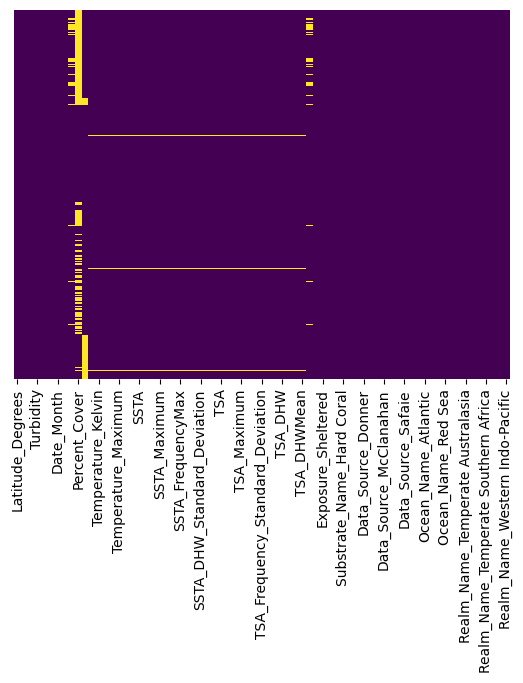

In [25]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [33]:
dataset[num_fea].isnull().sum()

Latitude_Degrees                             0
Longitude_Degrees                            0
Distance_to_Shore                            1
Turbidity                                    4
Cyclone_Frequency                            0
Date_Day                                     0
Date_Month                                   0
Date_Year                                    0
Percent_Cover                            12453
Percent_Bleaching                         3734
ClimSST                                     67
Temperature_Kelvin                          91
Temperature_Mean                            82
Temperature_Minimum                         82
Temperature_Maximum                         82
Temperature_Kelvin_Standard_Deviation       82
Windspeed                                   76
SSTA                                        91
SSTA_Standard_Deviation                     82
SSTA_Minimum                               104
SSTA_Maximum                                82
SSTA_Frequenc

We see the missing values of each feature and need to understand the reasons for the missing:
- MCAR: Completely random, no relationship
- MNAR: can be explained by not-null variable
- MAR: not at random, related to unobserved data

Temperature*, SSTA*, TSA* are MAR. We will handle it by KNN. Because, KNN is a multi-variable approach to handle missing values.

In [19]:
KNN = ['Temperature_Kelvin','Temperature_Mean','Temperature_Minimum','Temperature_Maximum',
'Temperature_Kelvin_Standard_Deviation','SSTA','SSTA_Standard_Deviation', 'SSTA_Minimum','SSTA_Maximum','SSTA_Frequency',
'SSTA_Frequency_Standard_Deviation','SSTA_FrequencyMax','SSTA_FrequencyMean',
'SSTA_DHW','SSTA_DHW_Standard_Deviation','SSTA_DHWMax','SSTA_DHWMean',
'TSA','TSA_Standard_Deviation','TSA_Minimum','TSA_Maximum','TSA_Mean',
'TSA_Frequency','TSA_Frequency_Standard_Deviation','TSA_FrequencyMax','TSA_FrequencyMean',
'TSA_DHW','TSA_DHW_Standard_Deviation','TSA_DHWMax','TSA_DHWMean']



In [22]:


num_pipeline = Pipeline([
    ('selector', ColumnSelector(KNN)),
    ('imputer', KNNImputer(n_neighbors=2)), # copy=False: imputation will be done in-place 
    ])  
  

In [29]:
SimImp = ['Distance_to_Shore','Turbidity','Percent_Cover','ClimSST','Deph_m']

In [30]:
num_pipeline = Pipeline([
    ('selector', ColumnSelector(SimImp)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median", copy=True)) # copy=False: imputation will be done in-place 
    ])  
  

In [20]:
dataset.fillna(value=np.median)

,Latitude_Degrees,Longitude_Degrees,Distance_to_Shore,Turbidity,Cyclone_Frequency,Date_Day,Date_Month,Date_Year,Depth_m,Percent_Cover,...,Ocean_Name_Red Sea,Realm_Name_Central Indo-Pacific,Realm_Name_Eastern Indo-Pacific,Realm_Name_Temperate Australasia,Realm_Name_Temperate Northern Atlantic,Realm_Name_Temperate Northern Pacific,Realm_Name_Temperate Southern Africa,Realm_Name_Tropical Atlantic,Realm_Name_Tropical Eastern Pacific,Realm_Name_Western Indo-Pacific
0,23.1630,-82.5260,8519.23,0.0287,49.90,15,9,2005,10,<function median at 0x000001E12BC55B80>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-17.5750,-149.7833,1431.62,0.0262,51.20,15,3,1991,14,<function median at 0x000001E12BC55B80>,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18.3690,-64.5640,182.33,0.0429,61.52,15,1,2006,7,<function median at 0x000001E12BC55B80>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,17.7600,-64.5680,313.13,0.0424,65.39,15,4,2006,9.02,<function median at 0x000001E12BC55B80>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,17.7690,-64.5830,792.0,0.0424,65.39,15,4,2006,12.50,<function median at 0x000001E12BC55B80>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41353,-3.2600,40.1500,1982.59,0.1505,42.73,12,4,2016,1.5,32.94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41354,-3.2600,40.1500,1982.59,0.1505,42.73,19,5,2016,2,19.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41355,-8.3651,116.0844,91.31,0.0372,47.39,28,5,2019,5.6,29.38,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41357,-8.3473,116.0503,129.08,0.0849,47.39,16,5,2019,3.5,13.75,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline) ])  

In [39]:
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())
print(processed_train_set_val.shape)
print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' %(len(num_fea)))


____________ Processed feature values ____________
[[7.17576e+03 7.16000e-02 1.06200e+01 3.01960e+02 3.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [2.79304e+03 7.51000e-02 7.50000e+00 3.00440e+02 6.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.16490e+02 8.41000e-02 2.93800e+01 3.01110e+02 1.00000e+01 1.00000e+00
  0.00000e+00 0.00000e+00 0.0000

Mean:  16.037402383888203
std : 7.837304958507597


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U6'), dtype('float64')) -> None